In [1]:
import xarray as xr
from dask.diagnostics import ProgressBar
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic
import xskillscore as xs

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import json
gcm = 'NorESM2-MM'
import sys

2024-07-28 04:12:53.299238: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
sys.path.append(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling')
from src.layers import *
from src.models import *
from src.gan import *
from ops.model_inference.src_eval_inference import *
os.chdir(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling')

In [18]:
adv_factor

0.01

In [15]:
adv_factor

0.01

In [3]:
df_nobn = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/Intensity_Penalty_nobn/{gcm}_Intensity_Penalty_nobn_hist_1986_2005_cascaded_perfect_applied.nc')
df_bn_ic = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/Intensity_Penalty/{gcm}_Intensity_Penalty_hist_1986_2005_cascaded_perfect_applied.nc')
df_tanh = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/Tanh_Activation/{gcm}_hist_1986_2005_cascaded_perfect_applied.nc')
df_leaky = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/LeakyRelu_Activation/NorESM2-MM_LeakyRelu_Activation_hist_1986_2005_cascaded_perfect_applied.nc')

In [23]:
df_nobn_normal_loss = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/outputs/Reviewer/Intensity_Con_Average_No_Ensemble_Mean/NorESM2-MM_IC_AC_hist_1985_2014_10_perfect_framework_v3.nc')

In [28]:
df_nobn_normal_loss.isel(member =0).

<xarray.Dataset>
Dimensions:     (experiment: 4)
Coordinates:
  * experiment  (experiment) float64 0.0 0.005 0.01 0.1
    GCM         <U10 'ACCESS-CM2'
Data variables:
    pr          (experiment) float32 600.9 575.5 721.5 574.1

In [5]:
crps_bn_ic = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/crps_outputs/Intensity_Penalty_crps.nc')
crps_bn = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/crps_outputs/Intensity_Penalty_crps.nc')

In [29]:
ground_truth = xr.open_dataset(r"/nesi/project/niwa00018/ML_downscaling_CCAM/multi-variate-gan/inputs/target_fields/target_fields_hist_ssp370_concat.nc").sel(GCM = gcm)
ground_truth['time'] = pd.to_datetime(ground_truth.time.dt.strftime("%Y-%m-%d"))
common_times = ground_truth.time.to_index().intersection(df_nobn_normal_loss.time.to_index())
with ProgressBar():
    ground_truth = ground_truth.sel(time = common_times).load()

In [35]:
# crps_tanh = xs.crps_ensemble(ground_truth.pr.isel(time = slice(0,3000)) *86400, df_tanh.pr.isel(time = slice(0,3000)), dim ="time")
# crps_tanh.to_netcdf('/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/crps_outputs/tanh_crps_3000_timesteps.nc')

crps_nobn_ic_normal_loss = xs.crps_ensemble(ground_truth.pr.isel(time = slice(0,3000)) *86400, df_nobn_normal_loss.pr.isel(time = slice(0,3000)), dim ="time")
crps_nobn_ic_normal_loss.to_netcdf('/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/crps_outputs/ic_nobn_normal_loss_crps_3000_timesteps.nc')

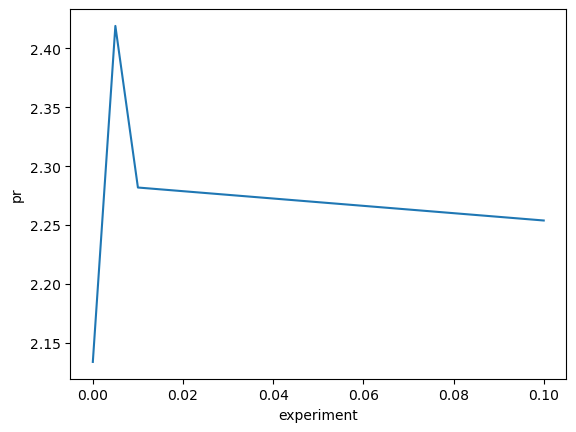

In [34]:
crps_nobn_ic_normal_loss.mean(["lat","lon"]).plot()

In [38]:
df1 = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/outputs/cascaded_perfect_framework_very_high_adv_intensity_constraint/CCAM_NIWA-REMS_NorESM2-MM_hist_ssp370_pr_ens.nc')
df1

<xarray.Dataset>
Dimensions:               (quantile: 11, lat: 172, lon: 179, season: 4, member: 3)
Coordinates:
  * lon                   (lon) float32 164.9 165.0 165.1 ... 183.7 183.9 184.0
  * lat                   (lat) float32 -51.21 -51.11 -51.0 ... -32.97 -32.86
  * quantile              (quantile) float64 0.5 0.7 0.9 ... 0.995 0.998 0.999
    GCM                   object ...
  * season                (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: member
Data variables:
    hist_quantiles        (quantile, lat, lon) float64 ...
    future_quantiles      (quantile, lat, lon) float64 ...
    cc_signal             (quantile, lat, lon) float64 ...
    seas_cc_signal        (season, member, lat, lon) float64 ...
    hist_clim_rainfall    (season, member, lat, lon) float64 ...
    future_clim_rainfall  (season, member, lat, lon) float64 ...

In [40]:
df = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/outputs/old_outputs/cascaded_perfect_framework_very_high_adv_linear_act/CCAM_NIWA-REMS_NorESM2-MM_hist_ssp370_pr.nc')

In [41]:
df

<xarray.Dataset>
Dimensions:               (quantile: 11, lat: 172, lon: 179, season: 4)
Coordinates:
  * lon                   (lon) float32 164.9 165.0 165.1 ... 183.7 183.9 184.0
  * lat                   (lat) float32 -51.21 -51.11 -51.0 ... -32.97 -32.86
  * quantile              (quantile) float64 0.5 0.7 0.9 ... 0.995 0.998 0.999
  * season                (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    hist_quantiles        (quantile, lat, lon) float64 ...
    future_quantiles      (quantile, lat, lon) float64 ...
    cc_signal             (quantile, lat, lon) float64 ...
    seas_cc_signal        (season, lat, lon) float64 ...
    hist_clim_rainfall    (season, lat, lon) float64 ...
    future_clim_rainfall  (season, lat, lon) float64 ...

In [46]:
df1 = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/outputs/old_outputs/Rain_Model_Med_Intensity_Constraint_Extreme/CCAM_NIWA-REMS_NorESM2-MM_hist_ssp370_pr.nc')
df2 = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/outputs/old_outputs/NIWA_REMS_high_adv_with_constraint/CCAM_NIWA-REMS_NorESM2-MM_hist_ssp370_pr.nc')
df3 = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/outputs/old_outputs/Rain_Model_Med_Intensity_Constraint/CCAM_NIWA-REMS_NorESM2-MM_hist_ssp370_pr.nc')

In [50]:
df1.isel(time =0)

<xarray.Dataset>
Dimensions:  (lat: 172, lon: 179)
Coordinates:
  * lon      (lon) float32 164.9 165.0 165.1 165.2 ... 183.6 183.7 183.9 184.0
  * lat      (lat) float32 -51.21 -51.11 -51.0 -50.89 ... -33.07 -32.97 -32.86
    GCM      <U10 'ACCESS-CM2'
    time     datetime64[ns] 1960-01-01
Data variables:
    pr       (lat, lon) float32 ...
Attributes: (12/28)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    history:         Tue Mar 12 14:54:26 2024: cdo merge /nesi/project/niwa00...
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data   /n ML Emulated NIWA-REMS GAN v1 G...
    il:              288
    ...              ...
    BC_version:      no output bias correction
    CMOR_v:          v1.0 Public
    CDO_call:        daymean computed on hourly data
    project:         NIWA CMIP6 Downscaling
    contact:         Peter Gibson (peter.gibson@niwa.co.nz)
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....

In [14]:
no_cons = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/crps_outputs/No_cons_NorESM2-MM.nc')

In [17]:
ic_nobn = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/crps_outputs/itensity_constrainted_NorESM2-MM.nc')

In [20]:
df22_ic_ec = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/crps_outputs/itensity_constrainted_ec_NorESM2-MM.nc')

In [56]:
labels = ['(1) GAN$_{ACCESS-CM2}$ IC, BN, $MSE(y_{pred}, y_{true})$, 3.5M Params',
          '(2) GAN$_{ACCESS-CM2}$ IC, $MSE(y_{pred}, y_{true})$, 3.5M Params',
          '(3) GAN$_{ACCESS-CM2}$ IC, $MSE(\sum_i y_{pred_i}, y_{true})$ 1.5M Params',
          '(1) Deterministic$_{ACCESS-CM2}$',
          '(2) Deterministic$_{ACCESS-CM2}$',
          '(3) Deterministic$_{ACCESS-CM2}$']

In [66]:
orog

NameError: name 'orog' is not defined

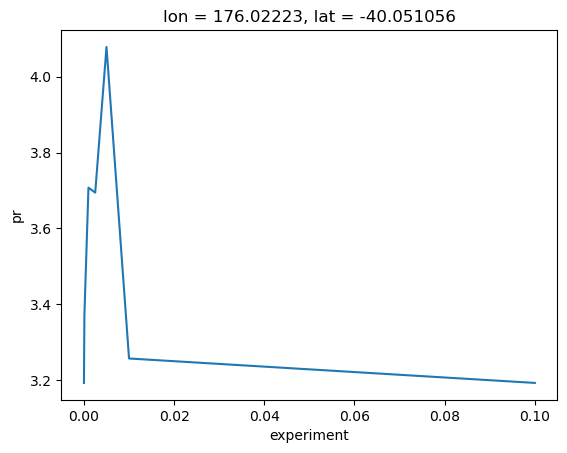

In [69]:
ic_nobn.pr.sel(lat =-40, lon =176, method ='nearest').plot()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7, 7))
#ax = ax.ravel()

# Define colors and markers
colors = ['#0072B2', '#E69F00', '#D55E00', '#CC79A7']
markers = ['o', 's', 'D', '>']
labels = ['(1) GAN$_{E}$ IC, $MSE(\sum_i y_{pred_i}, y_{true})$, 1.5M Params', '(1) GAN$_{A}$ IC, $MSE(\sum_i y_{pred_i}, y_{true})$, 1.5M Params',
          '(1) GAN$_{E}$ IC, $MSE( y_{pred}, y_{true})$, 3.5M Params',
          '(1) Deterministic$_{E}$',
          '(2) Deterministic$_{A}$',
          '(3) Deterministic$_{A}$']
ax = [ax]
i =0
# Plot data with adjusted colors and markers

df22_ic_ec.pr.mean(["lat","lon"]).isel(experiment=slice(1, None)).to_pandas().plot(ax=ax[i], marker=markers[0], color=colors[0], label='GAN', ls='-', ms = 8, lw =3)
ic_nobn.pr.mean(["lat","lon"]).isel(experiment=slice(1, None)).to_pandas().plot(ax=ax[i], marker=markers[1], color=colors[1], label='GAN \n(Intensity Constraint)', ls='-', ms =8, lw =3)

#var_lr_N.isel(experiment=slice(1, None)).to_pandas().plot(ax=ax[i], marker=markers[2], color=colors[2], label='GAN \n (Average Constraint)', ls='-', alpha=0.6, ms =9)
crps_nobn_ic.mean(["lat","lon"]).isel(experiment=slice(1, None)).to_pandas().plot(ax=ax[i], marker=markers[2], color=colors[2], label='GAN \n (Intensity Constraint/ EC-Earth3)', ls='-', alpha=0.6, ms =9)
#crps_bn.pr.mean(["lat","lon"]).isel(experiment=slice(1, None)).to_pandas().plot(ax=ax[i], marker=markers[3], color=colors[3], label='GAN \n (Intensity Constraint/ EC-Earth3)', ls='-', alpha=0.6, ms =9)

ax[i].axhline(df22_ic_ec.pr.mean(["lat","lon"]).isel(experiment =0).values, color = colors[0], alpha =0.8,label='GAN',ls ='--')
ax[i].axhline(ic_nobn.pr.mean(["lat","lon"]).isel(experiment =0).values, color = colors[1], alpha =0.8,label='GAN \n(Intensity Constraint)', ls ='--')
ax[i].axhline(crps_nobn_ic.mean(["lat","lon"]).isel(experiment =0).values, color = colors[2], alpha =0.8,label='GAN \n(Intensity Constraint)', ls ='--')
#ax[i].axhline(crps_bn.pr.mean(["lat","lon"]).isel(experiment =0).values, color = colors[3], alpha =0.8,label='GAN \n(Intensity Constraint)', ls ='--')

# ax[i].scatter(0.11, var_lr_N.isel(experiment =0).values, s =150, color = colors[2], alpha =0.6)
    # ax[i].scatter(0.11, var_ic_N.isel(experiment =0).values, s =150, color = colors[3], alpha =0.6)
# Add other subplots similarly

# Add legend and other configurations
for axis in ax:
    #axis.legend()
    #axis.set_yscale('log')
    axis.set_xscale('log')
    axis.tick_params(labelsize =15)
    axis.set_xlim(8e-5, 0.14)
    axis.set_xlabel(' ')
    #axis.set_ylim(0, axis.get_ylim()[-1])
    axis.grid('on')
ax[i].set_xlabel('$\lambda_{adv}$', fontsize =16)
ax[i].set_ylabel('CRPS (mm/day)', fontsize =16)
# ax[1].set_ylim(0, 1.5)   
# ax[-1].set_xlabel('$\lambda_{adv}$', fontsize=18)
# ax[-2].set_xlabel('$\lambda_{adv}$', fontsize=18)
# ax[0].set_ylabel('DJF MAE (mm/day)', fontsize =12, weight ='bold')
# ax[1].set_ylabel('JJA MAE (mm/day)', fontsize =15, weight ='bold')
# ax[2].set_ylabel('RX1Day MAE (mm/day)', fontsize =15, weight ='bold')
# ax[3].set_ylabel('CDD MAE (mm/day)', fontsize =15, weight ='bold')
# ax[0].set_title('(a) DJF', weight ='bold', fontsize =18)
# ax[1].set_title('(b) JJA', weight ='bold', fontsize =18)
# ax[2].set_title('(c) RX1Day', weight ='bold', fontsize =18)
# ax[3].set_title('(d) CDD', weight ='bold', fontsize =18)
fig.legend(labels=labels, loc='lower right', ncol=1, fontsize =10, bbox_to_anchor = (1.56, 0.12))
plt.tight_layout()
fig.savefig(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/pixelwise_crps_supplmentary_nobn_comparison.png', dpi =500, bbox_inches ='tight')
fig.savefig(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/pixelwise_crps.pdf', dpi =500, bbox_inches ='tight')
plt.show()


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7, 7))
#ax = ax.ravel()

# Define colors and markers
colors = ['#0072B2', '#E69F00', '#D55E00', '#CC79A7']
markers = ['o', 's', 'D', '>']
labels = ['(1) GAN$_{E}$ IC, $MSE(\sum_i y_{pred_i}, y_{true})$, 1.5M Params', '(1) GAN$_{A}$ IC, $MSE(\sum_i y_{pred_i}, y_{true})$, 1.5M Params',
          '(1) GAN$_{E}$ IC, $MSE(\sum_i y_{pred_i}, y_{true})$, 3.5M Params',
          '(1) Deterministic$_{E}$',
          '(2) Deterministic$_{A}$',
          '(3) Deterministic$_{A}$']
ax = [ax]
i =0
# Plot data with adjusted colors and markers

df_leaky.pr.mean(["lat","lon"]).isel(experiment=slice(1, None)).to_pandas().plot(ax=ax[i], marker=markers[0], color=colors[0], label='GAN', ls='-', ms = 8, lw =3)
df_tanh.pr.mean(["lat","lon"]).isel(experiment=slice(1, None)).to_pandas().plot(ax=ax[i], marker=markers[1], color=colors[1], label='GAN \n(Intensity Constraint)', ls='-', ms =8, lw =3)

#var_lr_N.isel(experiment=slice(1, None)).to_pandas().plot(ax=ax[i], marker=markers[2], color=colors[2], label='GAN \n (Average Constraint)', ls='-', alpha=0.6, ms =9)
crps_nobn_ic.mean(["lat","lon"]).isel(experiment=slice(1, None)).to_pandas().plot(ax=ax[i], marker=markers[2], color=colors[2], label='GAN \n (Intensity Constraint/ EC-Earth3)', ls='-', alpha=0.6, ms =9)
#crps_bn.pr.mean(["lat","lon"]).isel(experiment=slice(1, None)).to_pandas().plot(ax=ax[i], marker=markers[3], color=colors[3], label='GAN \n (Intensity Constraint/ EC-Earth3)', ls='-', alpha=0.6, ms =9)

ax[i].axhline(df_leaky.pr.mean(["lat","lon"]).isel(experiment =0).values, color = colors[0], alpha =0.8,label='GAN',ls ='--')
ax[i].axhline(df_tanh.pr.mean(["lat","lon"]).isel(experiment =0).values, color = colors[1], alpha =0.8,label='GAN \n(Intensity Constraint)', ls ='--')
#ax[i].axhline(crps_nobn_ic.mean(["lat","lon"]).isel(experiment =0).values, color = colors[2], alpha =0.8,label='GAN \n(Intensity Constraint)', ls ='--')
#ax[i].axhline(crps_bn.pr.mean(["lat","lon"]).isel(experiment =0).values, color = colors[3], alpha =0.8,label='GAN \n(Intensity Constraint)', ls ='--')

# ax[i].scatter(0.11, var_lr_N.isel(experiment =0).values, s =150, color = colors[2], alpha =0.6)
    # ax[i].scatter(0.11, var_ic_N.isel(experiment =0).values, s =150, color = colors[3], alpha =0.6)
# Add other subplots similarly

# Add legend and other configurations
for axis in ax:
    #axis.legend()
    #axis.set_yscale('log')
    axis.set_xscale('log')
    axis.tick_params(labelsize =15)
    axis.set_xlim(8e-5, 0.14)
    axis.set_xlabel(' ')
    #axis.set_ylim(0, axis.get_ylim()[-1])
    axis.grid('on')
ax[i].set_xlabel('$\lambda_{adv}$', fontsize =16)
ax[i].set_ylabel('CRPS (mm/day)', fontsize =16)
# ax[1].set_ylim(0, 1.5)   
# ax[-1].set_xlabel('$\lambda_{adv}$', fontsize=18)
# ax[-2].set_xlabel('$\lambda_{adv}$', fontsize=18)
# ax[0].set_ylabel('DJF MAE (mm/day)', fontsize =12, weight ='bold')
# ax[1].set_ylabel('JJA MAE (mm/day)', fontsize =15, weight ='bold')
# ax[2].set_ylabel('RX1Day MAE (mm/day)', fontsize =15, weight ='bold')
# ax[3].set_ylabel('CDD MAE (mm/day)', fontsize =15, weight ='bold')
# ax[0].set_title('(a) DJF', weight ='bold', fontsize =18)
# ax[1].set_title('(b) JJA', weight ='bold', fontsize =18)
# ax[2].set_title('(c) RX1Day', weight ='bold', fontsize =18)
# ax[3].set_title('(d) CDD', weight ='bold', fontsize =18)
fig.legend(labels=labels, loc='lower right', ncol=1, fontsize =10, bbox_to_anchor = (1.56, 0.12))
plt.tight_layout()
#fig.savefig(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/pixelwise_crps_supplmentary_nobn_comparison.png', dpi =500, bbox_inches ='tight')
#fig.savefig(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/pixelwise_crps.pdf', dpi =500, bbox_inches ='tight')
plt.show()


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7, 7))
#ax = ax.ravel()

# Define colors and markers
colors = ['#0072B2', '#E69F00', '#D55E00', '#CC79A7']
markers = ['o', 's', 'D', '>']
labels = ['(1) GAN$_{A}$ IC, BN, $MSE(y_{pred}, y_{true})$, 1.5M Params', '(2) GAN$_{A}$ BN, $MSE(y_{pred}, y_{true})$, 1.5M Params',
          '(3) GAN$_{A}$ IC, $MSE(\sum_i y_{pred_i}, y_{true})$ 3.5M Params','(4) GAN$_{A}$, $MSE(\sum_i y_{pred_i}, y_{true})$ 3.5M Params',
          '(1) Deterministic$_{A}$',
          '(2) Deterministic$_{A}$',
         '(3) Deterministic$_{A}$',
         '(4) Deterministic$_{A}$']
ax = [ax]
i =0
# Plot data with adjusted colors and markers

ic_nobn.pr.mean(["lat","lon"]).isel(experiment=slice(1, None)).to_pandas().plot(ax=ax[i], marker=markers[0], color=colors[0], label='GAN', ls='-', ms = 8, lw =3)
ic_nobn.pr.mean(["lat","lon"]).isel(experiment=slice(1, None)).to_pandas().plot(ax=ax[i], marker=markers[1], color=colors[1], label='GAN \n(Intensity Constraint)', ls='-', ms =8, lw =3)

#var_lr_N.isel(experiment=slice(1, None)).to_pandas().plot(ax=ax[i], marker=markers[2], color=colors[2], label='GAN \n (Average Constraint)', ls='-', alpha=0.6, ms =9)
crps_bn_ic.mean(["lat","lon"]).isel(experiment=slice(1, None)).to_pandas().plot(ax=ax[i], marker=markers[2], color=colors[2], label='GAN \n (Intensity Constraint/ EC-Earth3)', ls='-', alpha=0.6, ms =9)
crps_bn.pr.mean(["lat","lon"]).isel(experiment=slice(1, None)).to_pandas().plot(ax=ax[i], marker=markers[3], color=colors[3], label='GAN \n (Intensity Constraint/ EC-Earth3)', ls='-', alpha=0.6, ms =9)

ax[i].axhline(no_cons.mean(["lat","lon"]).pr.isel(experiment =0).values, color = colors[0], alpha =0.8,label='GAN',ls ='--')
ax[i].axhline(ic_nobn.mean(["lat","lon"]).pr.isel(experiment =0).values, color = colors[1], alpha =0.8,label='GAN \n(Intensity Constraint)', ls ='--')
ax[i].axhline(crps_bn_ic.mean(["lat","lon"]).isel(experiment =0).values, color = colors[2], alpha =0.8,label='GAN \n(Intensity Constraint)', ls ='--')
ax[i].axhline(crps_bn.pr.mean(["lat","lon"]).isel(experiment =0).values, color = colors[3], alpha =0.8,label='GAN \n(Intensity Constraint)', ls ='--')

# ax[i].scatter(0.11, var_lr_N.isel(experiment =0).values, s =150, color = colors[2], alpha =0.6)
    # ax[i].scatter(0.11, var_ic_N.isel(experiment =0).values, s =150, color = colors[3], alpha =0.6)
# Add other subplots similarly

# Add legend and other configurations
for axis in ax:
    #axis.legend()
    #axis.set_yscale('log')
    axis.set_xscale('log')
    axis.tick_params(labelsize =15)
    axis.set_xlim(8e-5, 0.14)
    axis.set_xlabel(' ')
    #axis.set_ylim(0, axis.get_ylim()[-1])
    axis.grid('on')
ax[i].set_xlabel('$\lambda_{adv}$', fontsize =16)
ax[i].set_ylabel('CRPS (mm/day)', fontsize =16)
# ax[1].set_ylim(0, 1.5)   
# ax[-1].set_xlabel('$\lambda_{adv}$', fontsize=18)
# ax[-2].set_xlabel('$\lambda_{adv}$', fontsize=18)
# ax[0].set_ylabel('DJF MAE (mm/day)', fontsize =12, weight ='bold')
# ax[1].set_ylabel('JJA MAE (mm/day)', fontsize =15, weight ='bold')
# ax[2].set_ylabel('RX1Day MAE (mm/day)', fontsize =15, weight ='bold')
# ax[3].set_ylabel('CDD MAE (mm/day)', fontsize =15, weight ='bold')
# ax[0].set_title('(a) DJF', weight ='bold', fontsize =18)
# ax[1].set_title('(b) JJA', weight ='bold', fontsize =18)
# ax[2].set_title('(c) RX1Day', weight ='bold', fontsize =18)
# ax[3].set_title('(d) CDD', weight ='bold', fontsize =18)
fig.legend(labels=labels, loc='lower right', ncol=1, fontsize =10, bbox_to_anchor = (1.56, 0.12))
plt.tight_layout()
fig.savefig(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/pixelwise_crps.png', dpi =500, bbox_inches ='tight')
fig.savefig(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/pixelwise_crps.pdf', dpi =500, bbox_inches ='tight')
plt.show()


No handles with labels found to put in legend.


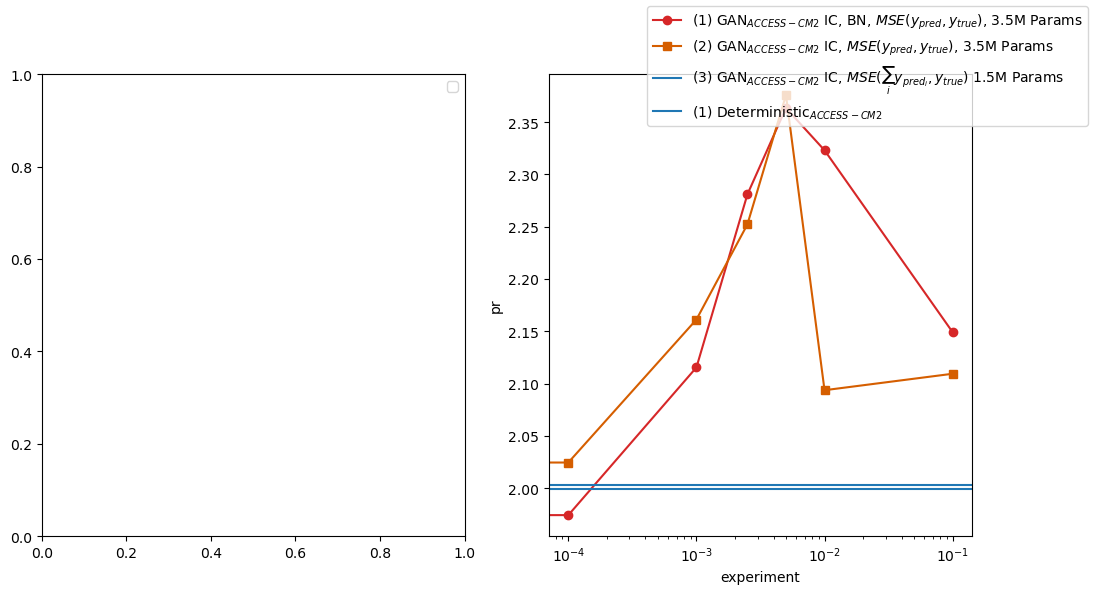

In [78]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
colors = ['#0072B2', '#E69F00', '#D55E00', 'tab:red','tab:green', 'yellow']
markers = ['o', 's', 'D','x','o','>']
#crps_bn_ic.mean(["lat","lon"]).plot(color =colors[0], ax = ax[1], marker =markers[0])
#crps_bn_ic.mean(["lat","lon"]).plot(color =colors[0], ax = ax[1], marker =markers[0])
#crps_tanh.mean(["lat","lon"]).plot(color =colors[1], ax = ax[1], marker =markers[1])
#crps_nobn_ic.mean(["lat","lon"]).plot(color =colors[1], ax = ax[1], marker =markers[2])
no_cons.mean(["lat","lon"]).pr.plot(color =colors[3], ax = ax[1], marker =markers[0])
ic_nobn.mean(["lat","lon"]).pr.plot(color =colors[2], ax = ax[1], marker =markers[1])
ax[1].axhline(no_cons.mean(["lat","lon"]).isel(experiment =0).pr.values)
ax[1].axhline(ic_nobn.mean(["lat","lon"]).isel(experiment =0).pr.values)
#df22_ic_ec.mean(["lat","lon"]).pr.plot(color =colors[3], ax = ax[1], marker =markers[-1])
plt.xscale('log')
fig.legend(labels)
ax[0].legend()

In [155]:
z = (df2.isel(time = slice(0,1200)).pr < ground_truth.pr.isel(time = slice(0,1200))*86400).sum("member")
ranks = [stats.binned_statistic(x = z.isel(experiment =i).values.ravel(),values =z.values.ravel(), statistic ='count', bins = np.arange(-0.005, 11, 1))[0] for i in range(0, 7)]

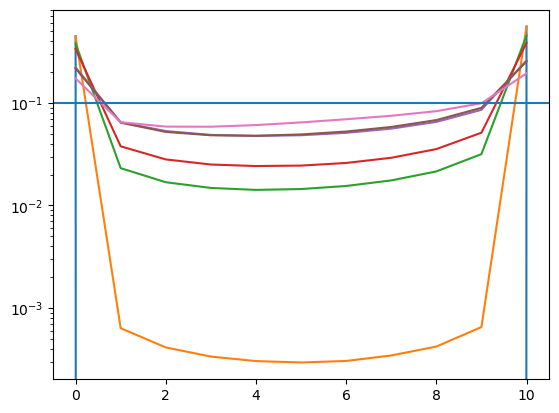

In [156]:
[plt.plot(ranks[i]/sum(ranks[i])) for i in range(7)]
plt.axhline(0.1)
plt.yscale('log')

In [157]:
z = (df.isel(time = slice(0,1200)).pr < ground_truth.pr.isel(time = slice(0,1200))*86400).sum("member")
ranks2 = [stats.binned_statistic(x = z.isel(experiment =i).values.ravel(),values =z.values.ravel(), statistic ='count', bins = np.arange(-0.005, 11, 1))[0] for i in range(0, 7)]

In [173]:
z2 = (ic_data.pr < ground_truth.pr.sel(time = ic_data.time.to_index().intersection(ground_truth.time.to_index()))*86400).sum("member")
ranks22 = [stats.binned_statistic(x = z2.isel(experiment =i).values.ravel(),values =z2.values.ravel(), statistic ='count', bins = np.arange(-0.005, 11, 1))[0] for i in range(0, 7)]

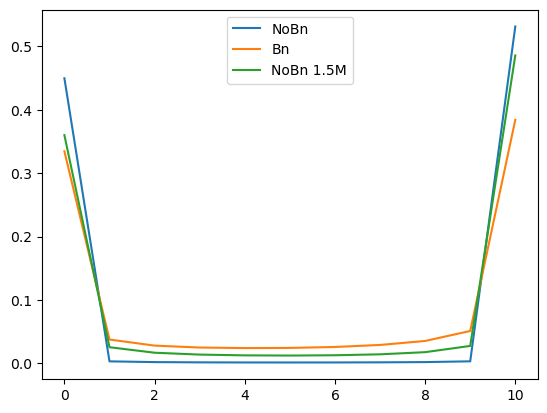

In [186]:
fig, ax = plt.subplots()
plt.plot(ranks2[3]/sum(ranks2[3]), label ='NoBn')
plt.plot(ranks[3]/sum(ranks[3]), label ='Bn')
plt.plot(ranks22[3]/sum(ranks22[3]), label ='NoBn 1.5M')
ax.legend()

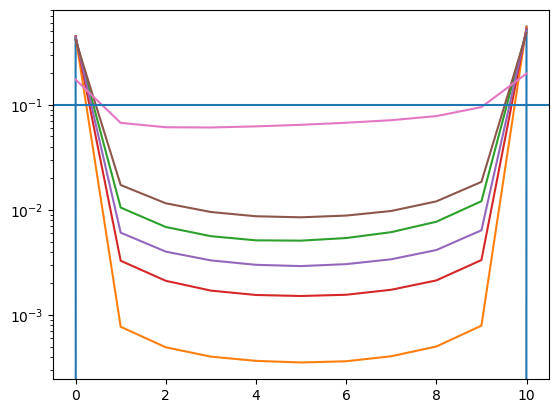

In [119]:
[plt.plot(ranks[i]/sum(ranks[i])) for i in range(7)]
plt.axhline(0.1)
plt.yscale('log')

In [121]:
crps_behaviour = xs.crps_ensemble(ground_truth.pr.isel(time = slice(0,1200))*86400, df.isel(time = slice(0,1200)).pr, dim ="time")

In [124]:
crps_behaviour_other = xs.crps_ensemble(ground_truth.pr.isel(time = slice(0,1200))*86400, df2.isel(time = slice(0,1200)).pr, dim ="time")

In [ ]:
crps_behaviour_other = xs.crps_ensemble(ground_truth.pr.isel(time = slice(0,1200))*86400, df2.isel(time = slice(0,1200)).pr, dim ="time")

In [134]:
ground_truth.sel(time = ic_data.time.to_index().intersection(ground_truth.time.to_index()))

<xarray.Dataset>
Dimensions:     (time: 1825, bnds: 2, lon: 179, lat: 172)
Coordinates:
  * time        (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2005-12-31
  * lon         (lon) float32 164.9 165.0 165.1 165.2 ... 183.7 183.9 184.0
  * lat         (lat) float32 -51.21 -51.11 -51.0 ... -33.07 -32.97 -32.86
    GCM         <U10 'NorESM2-MM'
Dimensions without coordinates: bnds
Data variables:
    time_bnds   (time, bnds) object 2001-01-01 00:30:00 ... 2005-12-31 23:30:00
    lon_bnds    (lon, bnds) float32 164.8 164.9 164.9 ... 183.9 183.9 184.0
    lat_bnds    (lat, bnds) float32 -51.27 -51.16 -51.16 ... -32.91 -32.81
    pr          (time, lat, lon) float32 1.839e-05 1.736e-05 ... 1.288e-06
    psl         (time, lat, lon) float32 9.779e+04 9.778e+04 ... 1.017e+05
    sfcWind     (time, lat, lon) float32 15.62 15.51 15.4 ... 8.567 8.6 8.594
    sfcWindmax  (time, lat, lon) float32 17.7 17.75 17.78 ... 10.84 10.71 10.62
    tasmax      (time, lat, lon) float32 282.6 282.6 282.6 ... 294.4 294.3 294.3
    tasmin      (time, lat, lon) float32 280.8 280.8 280.8 ... 292.6 292.6 292.5
Attributes: (12/28)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    history:         Tue Mar 12 14:54:26 2024: cdo merge /nesi/project/niwa00...
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    il:              288
    ...              ...
    BC_version:      no output bias correction
    CMOR_v:          v1.0 Public
    CDO_call:        daymean computed on hourly data
    project:         NIWA CMIP6 Downscaling
    contact:         Peter Gibson (peter.gibson@niwa.co.nz)
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....

In [137]:
df = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/validation_netcdfs/Intensity_Penalty/NorESM2-MM_Intensity_Penalty_hist_1986_2005_cascaded_perfect_applied_val_metrics.nc')
ground_truth = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/validation_netcdfs/Tanh_Activation/EC-Earth3_hist_1986_2005_ground_truth_applied_val_metrics.nc')

In [139]:
ground_truth = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/validation_netcdfs/Tanh_Activation/EC-Earth3_hist_1986_2005_ground_truth_applied_val_metrics.nc')

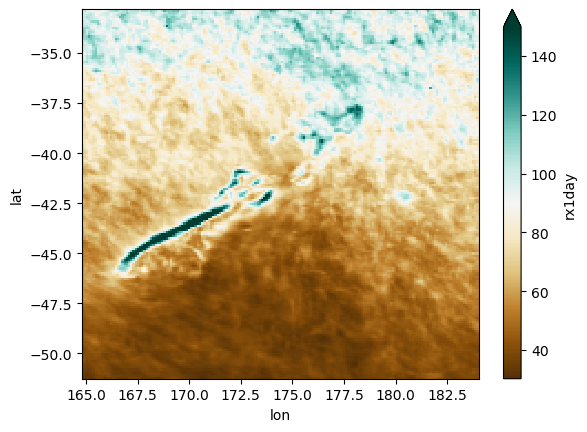

In [146]:
ground_truth.mean("year").rx1day.plot(cmap ='BrBG', vmax =150)

In [ ]:
with ProgressBar():
    ic_data = xr.open_mfdataset(f'{base_dir}/Intensity_Constrained/{gcm}_*2001_2014_10*v2.nc').load()
#     ec_ic_trained = xr.open_mfdataset(f'{base_dir}/EC-Earth3/{gcm}_*2001_2014_10*v2.nc').load()
#     no_cons = xr.open_mfdataset(f'{base_dir}/No_Constraint/{gcm}_*2001_2014_10*v2.nc').load()
#     ic_ac_data = xr.open_mfdataset(f'{base_dir}/Intensity_Con_Average/{gcm}_*2001_2014_10*v2.nc').load()

In [135]:
crps_behaviour_other_v2 = xs.crps_ensemble(ground_truth.sel(time = ic_data.time.to_index().intersection(ground_truth.time.to_index())).pr*86400, ic_data.sel(time = ic_data.time.to_index().intersection(ground_truth.time.to_index())).pr, dim ="time")

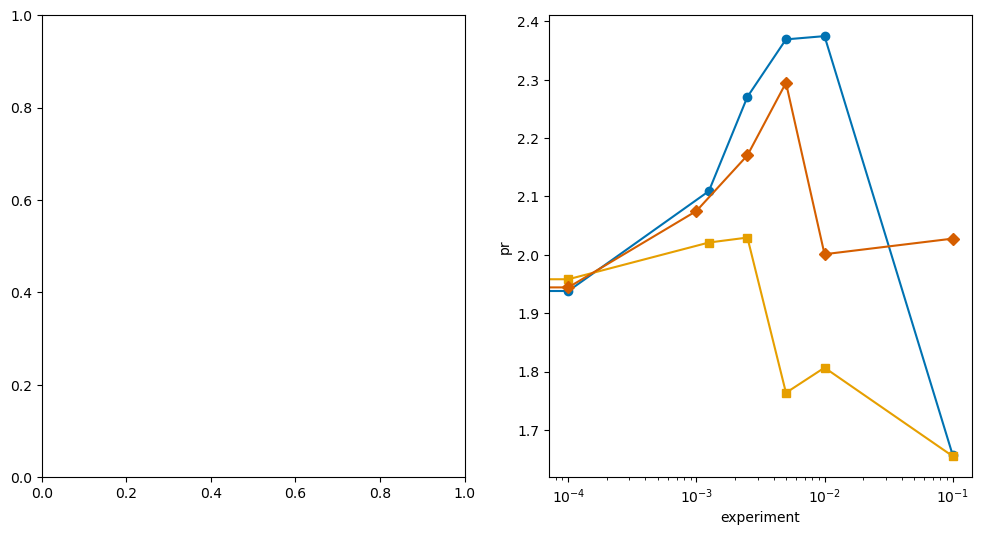

In [190]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
colors = ['#0072B2', '#E69F00', '#D55E00']
markers = ['o', 's', 'D']
crps_behaviour.mean(["lat","lon"]).plot(color =colors[0], ax = ax[1], marker =markers[0])
crps_behaviour_other.mean(["lat","lon"]).plot(color =colors[1], ax = ax[1], marker =markers[1])
crps_behaviour_other_v2.mean(["lat","lon"]).plot(color =colors[2], ax = ax[1], marker =markers[2])
plt.xscale('log')

In [95]:
zs = [z.where(z ==i).sum().values for i in range(-1, 11)]

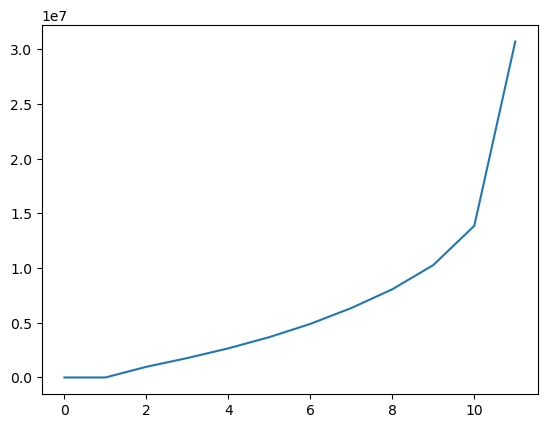

In [96]:
plt.plot(zs)

In [51]:
np.arange(-0.005, 10, 1)

array([-5.000e-03,  9.950e-01,  1.995e+00,  2.995e+00,  3.995e+00,
        4.995e+00,  5.995e+00,  6.995e+00,  7.995e+00,  8.995e+00,
        9.995e+00])

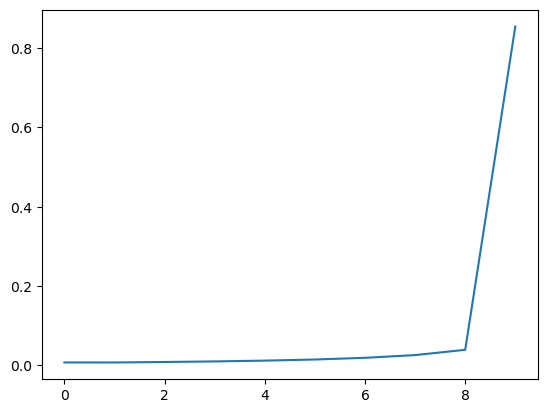

In [63]:
plt.plot(ranks[0]/sum(ranks[0]))

In [72]:
ground_truth

<xarray.Dataset>
Dimensions:     (time: 7300, bnds: 2, lon: 179, lat: 172)
Coordinates:
  * time        (time) datetime64[ns] 1986-01-01 1986-01-02 ... 2005-12-31
  * lon         (lon) float32 164.9 165.0 165.1 165.2 ... 183.7 183.9 184.0
  * lat         (lat) float32 -51.21 -51.11 -51.0 ... -33.07 -32.97 -32.86
    GCM         <U10 'NorESM2-MM'
Dimensions without coordinates: bnds
Data variables:
    time_bnds   (time, bnds) object 1986-01-01 00:30:00 ... 2005-12-31 23:30:00
    lon_bnds    (lon, bnds) float32 164.8 164.9 164.9 ... 183.9 183.9 184.0
    lat_bnds    (lat, bnds) float32 -51.27 -51.16 -51.16 ... -32.91 -32.81
    pr          (time, lat, lon) float32 0.0001842 0.0002039 ... 1.288e-06
    psl         (time, lat, lon) float32 9.976e+04 9.977e+04 ... 1.017e+05
    sfcWind     (time, lat, lon) float32 10.14 9.981 9.811 ... 8.567 8.6 8.594
    sfcWindmax  (time, lat, lon) float32 15.51 15.42 15.33 ... 10.84 10.71 10.62
    tasmax      (time, lat, lon) float32 283.3 283.3 283.3 ... 294.4 294.3 294.3
    tasmin      (time, lat, lon) float32 282.8 282.8 282.7 ... 292.6 292.6 292.5
Attributes: (12/28)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    history:         Tue Mar 12 14:54:26 2024: cdo merge /nesi/project/niwa00...
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    il:              288
    ...              ...
    BC_version:      no output bias correction
    CMOR_v:          v1.0 Public
    CDO_call:        daymean computed on hourly data
    project:         NIWA CMIP6 Downscaling
    contact:         Peter Gibson (peter.gibson@niwa.co.nz)
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....

In [ ]:
df2.isel(time = slice(0,1200), experiment =-1)

In [73]:
ranks2 = xs.rank_histogram(ground_truth.pr.sel(time = df2.time.to_index()[0:700]),df2.sel(time = df2.time.to_index()[0:700]).isel(experiment =-1).pr.clip(0.0, 1000))

ZeroDivisionError: integer division or modulo by zero

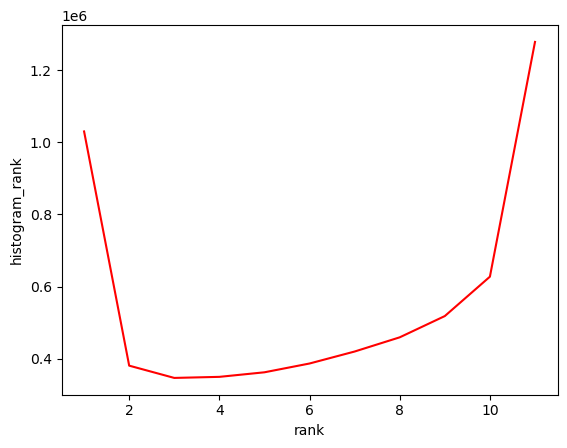

In [67]:
#ranks.plot()
ranks2.plot(color ='r')

In [ ]:
df2 = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/LeakyRelu_Activation/EC-Earth3_LeakyRelu_Activation_hist_1986_2005_cascaded_perfect_applied.nc')

In [ ]:
df2

In [6]:
# custom modules
import sys
sys.path.append(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling')
from src.layers import *
from src.models import *
from src.gan import *
from src.process_input_training_data import *
# config["train_x"] = f"{tmp_dir}/{config['train_x'].split('/')[-1]}"
# config["train_y"] = f"{tmp_dir}/{config['train_y'].split('/')[-1]}"

In [131]:
base_dir = '/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/outputs/Reviewer'
gcm = 'NorESM2-MM'

In [213]:
import xskillscore as xs

In [132]:
with ProgressBar():
    ic_data = xr.open_mfdataset(f'{base_dir}/Intensity_Constrained/{gcm}_*2001_2014_10*v2.nc').load()
#     ec_ic_trained = xr.open_mfdataset(f'{base_dir}/EC-Earth3/{gcm}_*2001_2014_10*v2.nc').load()
#     no_cons = xr.open_mfdataset(f'{base_dir}/No_Constraint/{gcm}_*2001_2014_10*v2.nc').load()
#     ic_ac_data = xr.open_mfdataset(f'{base_dir}/Intensity_Con_Average/{gcm}_*2001_2014_10*v2.nc').load()

[########################################] | 100% Completed |  1min 51.3s


In [317]:
ic_data.nbytes/1e9

44.05151278

In [318]:
ground_truth = xr.open_dataset(r"/nesi/project/niwa00018/ML_downscaling_CCAM/multi-variate-gan/inputs/target_fields/target_fields_hist_ssp370_concat.nc").sel(GCM = gcm)
ground_truth['time'] = pd.to_datetime(ground_truth.time.dt.strftime("%Y-%m-%d"))
common_times = ground_truth.time.to_index().intersection(no_cons.time.to_index())
with ProgressBar():
    ground_truth = ground_truth.sel(time = common_times).load()

In [319]:
stds_true = ((ground_truth.sel(time = ic_data.time).pr*86400)).std("time")#.mean(["lat","lon"])

In [322]:
# stds2 = ic_data.std("time").isel(member =0)#.mean("member")#.mean(["lat","lon"])
# stds3 = ec_ic_trained.std("time").isel(member =0)#.mean("member")#.mean(["lat","lon"])
stds = no_cons.clip(0,1000).std("time").isel(member =0)#.mean("member")#.mean(["lat","lon"])
ratio2 = 100 * stds2/stds_true
ratio = 100* stds/stds_true
ratio3 = 100* stds3/stds_true

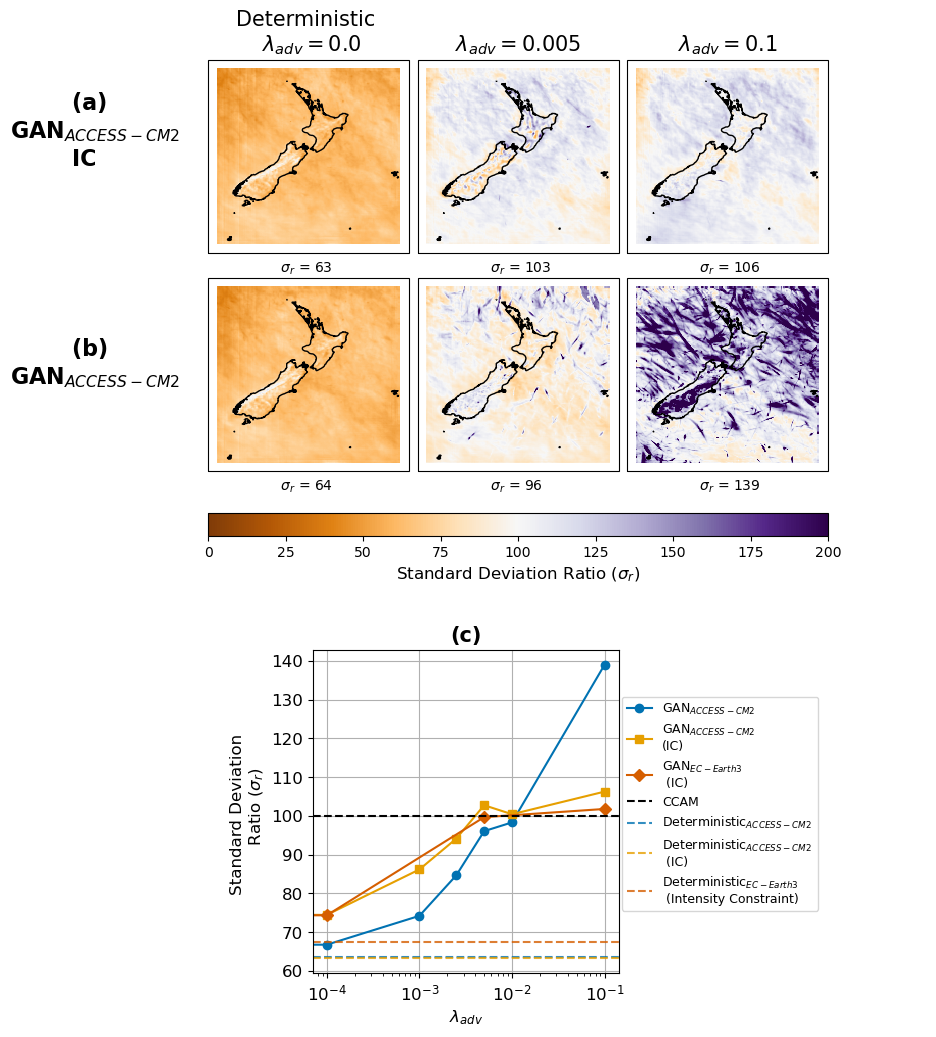

In [323]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
colors = ['#0072B2', '#E69F00', '#D55E00']
markers = ['o', 's', 'D']
# Create a figure
fig = plt.figure(figsize=(8, 12))

# Create a GridSpec with 2 rows and 2 columns
gs = gridspec.GridSpec(34, 12, figure=fig)

# Create subplots with Cartopy projections
ax1 = fig.add_subplot(gs[0:8, 0:4], projection=ccrs.PlateCarree(central_longitude =171.77))
ax2 = fig.add_subplot(gs[0:8, 4:8], projection=ccrs.PlateCarree(central_longitude =171.77))
ax3 = fig.add_subplot(gs[0:8, 8:], projection=ccrs.PlateCarree(central_longitude =171.77))
# Create subplots with Cartopy projections
ax4 = fig.add_subplot(gs[8:16, 0:4], projection=ccrs.PlateCarree(central_longitude =171.77))
ax5 = fig.add_subplot(gs[8:16, 4:8], projection=ccrs.PlateCarree(central_longitude =171.77))
ax6 = fig.add_subplot(gs[8:16, 8:], projection=ccrs.PlateCarree(central_longitude =171.77)) # Span the second row
cbar_ax = fig.add_subplot(gs[17,:])
ax7 = fig.add_subplot(gs[22:34, 2:8]) # Span the second row

ratio.pr.isel(experiment =0).plot(ax = ax4, transform = ccrs.PlateCarree(), cmap ='PuOr', add_colorbar =False, vmin =0, vmax =200)
ax4.text(171, -54.25, f' $\sigma_r$ = {"%.0f" % ratio.pr.isel(experiment =0).mean()}', transform = ccrs.PlateCarree())
ratio.pr.sel(experiment =0.005).plot(ax = ax5, transform = ccrs.PlateCarree(), cmap ='PuOr', add_colorbar =False, vmin =0, vmax =200)
ax5.text(171, -54.25, f' $\sigma_r$ = {"%.0f" % ratio.pr.sel(experiment =0.005).mean()}', transform = ccrs.PlateCarree())
ratio.pr.sel(experiment =0.1).plot(ax = ax6, transform = ccrs.PlateCarree(), cmap ='PuOr', add_colorbar =False, vmin =0, vmax =200)
ax6.text(171, -54.25, f' $\sigma_r$ = {"%.0f" % ratio.pr.sel(experiment =0.1).mean()}', transform = ccrs.PlateCarree())
ratio2.pr.isel(experiment =0).plot(ax = ax1, transform = ccrs.PlateCarree(), cmap ='PuOr', add_colorbar =False, vmin =0, vmax =200)
ax1.text(171, -54.25, f' $\sigma_r$ = {"%.0f" % ratio2.pr.isel(experiment =0).mean()}', transform = ccrs.PlateCarree())
ratio2.pr.sel(experiment =0.005).plot(ax = ax2, transform = ccrs.PlateCarree(), cmap ='PuOr', add_colorbar =False, vmin =0, vmax =200)
ax2.text(171, -54.25, f' $\sigma_r$ = {"%.0f" % ratio2.pr.sel(experiment =0.005).mean()}', transform = ccrs.PlateCarree())
cs = ratio2.pr.sel(experiment =0.1).plot(ax = ax3, transform = ccrs.PlateCarree(), cmap ='PuOr', add_colorbar =False, vmin =0, vmax =200)
ax3.text(171, -54.25, f' $\sigma_r$ = {"%.0f" % ratio2.pr.sel(experiment =0.1).mean()}', transform = ccrs.PlateCarree())
# Add coastlines to each subplot for context
for axes in (ax1, ax2, ax3, ax4, ax5, ax6):
    axes.coastlines('10m')
    axes.set_title(' ')
ax1.text(143, -43, '        (a) \nGAN$_{ACCESS-CM2}$ \n        IC', transform = ccrs.PlateCarree(), weight ='bold', fontsize =16)
ax4.text(143, -43, '        (b) \nGAN$_{ACCESS-CM2}$', transform = ccrs.PlateCarree(), weight ='bold', fontsize =16)
ax1.set_title('Deterministic \n $\lambda_{adv} =0.0$', fontsize =15)
ax2.set_title('$\lambda_{adv} =0.005$', fontsize =15)
ax3.set_title('$\lambda_{adv} =0.1$', fontsize =15)

cbar = fig.colorbar(cs, cax = cbar_ax, orientation ='horizontal', shrink =0.3)
cbar.set_label('Standard Deviation Ratio ($\sigma_r$)', fontsize =12)
ax = ax7
ratio.mean(["lat","lon"]).pr.plot(ax = ax, marker =markers[0], color = colors[0])
ratio2.mean(["lat","lon"]).pr.plot(ax = ax, marker =markers[1], color = colors[1])
ratio3.mean(["lat","lon"]).pr.plot(ax = ax, marker =markers[2], color = colors[2])
ax.set_xscale('log')
ax.axhline(100, color ='k', ls ='--')

ax.axhline(ratio.mean(["lat","lon"]).isel(experiment =0).pr.values, color = colors[0], alpha =0.8,label='GAN',ls ='--')
ax.axhline(ratio2.mean(["lat","lon"]).isel(experiment =0).pr.values, color = colors[1], alpha =0.8,label='GAN \n(Intensity Constraint)', ls ='--')
ax.axhline(ratio3.mean(["lat","lon"]).isel(experiment =0).pr.values, color = colors[2], alpha =0.8,label='GAN \n(Intensity Constraint)', ls ='--')
ax.grid('on')
ax.set_xlabel('$\lambda_{adv}$', fontsize = 12)
ax.set_ylabel('Standard Deviation \n  Ratio ($\sigma_r$)', fontsize =12)
ax.tick_params(labelsize =12)
ax.set_title('(c)', fontsize =15, weight ='bold')
fig.legend(labels=labels, loc='lower center', ncol=1, fontsize =9,bbox_to_anchor = (0.9, 0.1))
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/Temporal_vaiability_updated_full.png',
           dpi =500, bbox_inches ='tight')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/Temporal_vaiability_updated_full.pdf',
           dpi =500, bbox_inches ='tight')

In [339]:
ic_data

<xarray.Dataset>
Dimensions:     (experiment: 7, member: 10, time: 5110, lat: 172, lon: 179)
Coordinates:
  * experiment  (experiment) float64 0.0 0.0001 0.001 0.0025 0.005 0.01 0.1
  * lon         (lon) float32 164.9 165.0 165.1 165.2 ... 183.7 183.9 184.0
  * lat         (lat) float32 -51.21 -51.11 -51.0 ... -33.07 -32.97 -32.86
    GCM         <U10 'ACCESS-CM2'
  * time        (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2014-12-31
Dimensions without coordinates: member
Data variables:
    pr          (experiment, member, time, lat, lon) float32 3.182 ... 0.03103
Attributes: (12/28)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    history:         Tue Mar 12 14:54:26 2024: cdo merge /nesi/project/niwa00...
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    il:              288
    ...              ...
    BC_version:      no output bias correction
    CMOR_v:          v1.0 Public
    CDO_call:        daymean computed on hourly data
    project:         NIWA CMIP6 Downscaling
    contact:         Peter Gibson (peter.gibson@niwa.co.nz)
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....

In [340]:
ens_mean = ic_data.mean("member")


KeyboardInterrupt: 

In [ ]:
ens_mean_n = no_cons.mean("member")


In [ ]:
rmse_lr_ic = np.sqrt(abs(ens_mean - ground_truth.pr.sel(time = ic_data.time)*3600*24)**2)
rmss_lr_ic = np.sqrt((abs(ens_mean- ic_data.sel(time = ic_data.time).clip(0,1000))**2).mean("member"))

with ProgressBar():
    rmse_lr_ic = rmse_lr_ic.load()
    rmss_lr_ic = rmss_lr_ic.load()


In [329]:
rmss_lr_ic 

<xarray.Dataset>
Dimensions:     (experiment: 7, time: 5110, lat: 172, lon: 179)
Coordinates:
  * experiment  (experiment) float64 0.0 0.0001 0.001 0.0025 0.005 0.01 0.1
  * lon         (lon) float32 164.9 165.0 165.1 165.2 ... 183.7 183.9 184.0
  * lat         (lat) float32 -51.21 -51.11 -51.0 ... -33.07 -32.97 -32.86
    GCM         <U10 'ACCESS-CM2'
  * time        (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2014-12-31
Data variables:
    pr          (experiment, time, lat, lon) float32 2.384e-07 ... 0.541

In [330]:
rmse_lr

<xarray.Dataset>
Dimensions:     (experiment: 7, time: 5110, lat: 172, lon: 179)
Coordinates:
  * experiment  (experiment) float64 0.0 0.0001 0.001 0.0025 0.005 0.01 0.1
  * lon         (lon) float32 164.9 165.0 165.1 165.2 ... 183.7 183.9 184.0
  * lat         (lat) float32 -51.21 -51.11 -51.0 ... -33.07 -32.97 -32.86
  * time        (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2014-12-31
Data variables:
    pr          (experiment, time, lat, lon) float32 0.3961 0.7226 ... 0.003342

In [ ]:
rmse_lr = np.sqrt(abs(ens_mean_n - ground_truth.pr.sel(time = no_cons.time)*3600*24)**2)
rmss_lr = np.sqrt((abs(ens_mean_n - no_cons.sel(time = no_cons.time).clip(0,500))**2).mean("member"))

with ProgressBar():
    rmse_lr = rmse_lr.load()
    rmss_lr = rmss_lr.load()


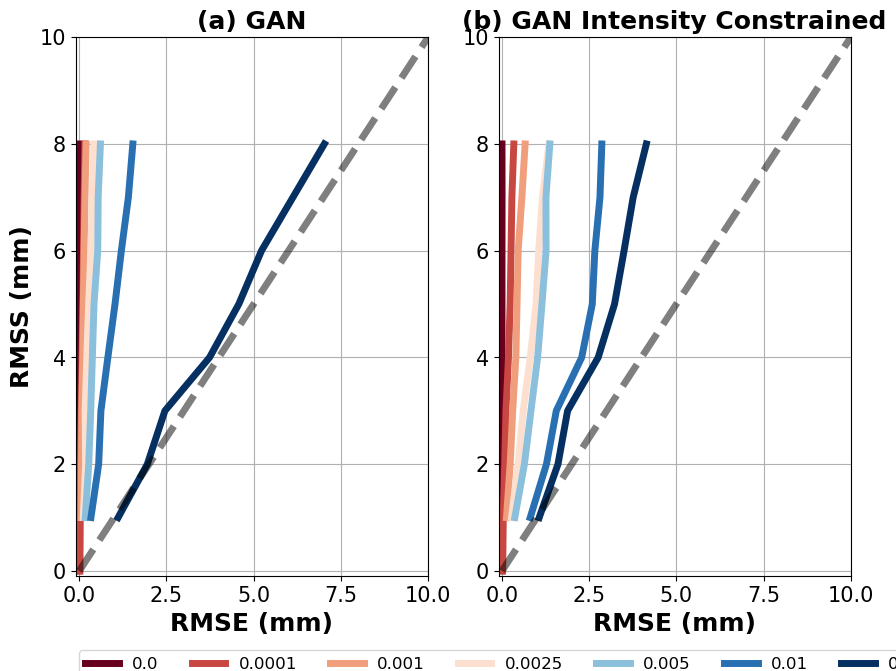

In [337]:


cmap = plt.cm.RdBu
marker_types = ['o', 's', '^', 'D', '*', 'x', 'P']
# Generate seven distinct colors, excluding white
colors = [cmap(i) for i in np.linspace(0,1, 25)]
colors_hist = [colors[0], colors[4], colors[7], colors[10], colors[17], colors[21], colors[-1]]


from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize = (10, 7))
factor = (10)/(10+1)
factor2 = (10)/(10-1)
bins =np.arange(0,10,1)
for i in range(7):
    x1 = binned_statistic(values=factor2 * rmss_lr.isel(experiment =i).mean("time").pr.values.ravel(), x=factor*rmse_lr.isel(experiment =i).mean("time").pr.values.ravel(),  statistic ='mean', bins =bins)
    #print(f"spread-ratio:{np.mean((1.11 * rmss_lr.isel(experiment =i).pr.values.ravel())/(0.9* rmse_lr.isel(experiment =i).pr.values.ravel()))}")
    ax[0].plot(x1[0], bins[:-1], label ='$\lambda_{adv}$=' +f'{rmse_lr.experiment.values[i]}', color = colors_hist[i], lw =5)
    x1 = binned_statistic(values=factor2 * rmss_lr_ic.isel(experiment =i).mean("time").pr.values.ravel(), x=factor*rmse_lr_ic.isel(experiment =i).mean("time").pr.values.ravel(),  statistic ='mean', bins =bins)
    #print(f"spread-ratio:{np.mean((1.11 * rmss_lr.isel(experiment =i).pr.values.ravel())/(0.9* rmse_lr.isel(experiment =i).pr.values.ravel()))}")
    ax[1].plot(x1[0], bins[:-1], label ='$\lambda_{adv}$=' +f'{rmse_lr.experiment.values[i]}', color = colors_hist[i], lw =5)
    #ax[1].scatter(x1[0], bins[:-1], color = colors_hist[i], marker = marker_types[i], s=35)

ax[0].plot([0,15], [0,15], ls ='--', color ='k', lw =5,alpha =0.5)
ax[0].grid('on')

ax[1].plot([0,15], [0,15], ls ='--', color ='k', lw =5,alpha =0.5)
ax[1].grid('on')


ax[0].set_xlim(-0.1, 10)
ax[0].set_ylim(-0.1,10)
ax[1].set_xlim(-0.1, 10)
ax[1].set_ylim(-0.1,10)

ax[0].set_xlabel('RMSE (mm)', fontsize=18, weight ='bold')
ax[1].set_xlabel('RMSE (mm)', fontsize=18, weight ='bold')
ax[0].set_ylabel('RMSS (mm)', fontsize=18, weight ='bold')
#ax[1].set_xlabel('RMSE (mm)', fontsize=18, weight ='bold')

ax[0].set_title('(a) GAN', weight ='bold', fontsize =18)
ax[1].set_title('(b) GAN Intensity Constrained', weight ='bold', fontsize =18)
ax[0].tick_params(labelsize =15)
ax[1].tick_params(labelsize =15)

#fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/overall_results/dispersion_relationship_9_4_24.png', dpi =700, bbox_inches ='tight')
#ax4 = fig.add_axes([0.1, 0.1, 0.5, 0.1])
fig.legend(labels=rmse_lr.experiment.values, loc='lower center', ncol=7, fontsize =12, bbox_to_anchor = (0.5, -0.023))

fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/dispersion_relationship.png', bbox_inches ='tight', dpi =500)
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/dispersion_relationship.pdf', bbox_inches ='tight', dpi =500)

In [197]:
dfrank_ic_ac = (ic_ac_data.pr.sel(time = common_times).where(ic_ac_data .pr.sel(time = common_times)> 0.001, 0.0).clip(0,1000) > ground_truth.pr.sel(time = common_times)*3600*24).sum("member")/50.0
dfrank= (no_cons.pr.sel(time = common_times).where(no_cons.pr.sel(time = common_times)> 0.001, 0.0).clip(0,1000) > ground_truth.pr.sel(time = common_times)*3600*24).sum("member")/50.0
dfrank_ec_ic= (ec_ic_trained.pr.sel(time = common_times).where(ec_ic_trained.pr.sel(time = common_times)> 0.001, 0.0).clip(0,1000) > ground_truth.pr.sel(time = common_times)*3600*24).sum("member")/50.0
dfrank_ic = (ic_data.pr.sel(time = common_times).where(ic_data .pr.sel(time = common_times)> 0.001, 0.0).clip(0,1000) > ground_truth.pr.sel(time = common_times)*3600*24).sum("member")/50.0

In [52]:
ic_data.isel(member =0).max(["time","lat","lon"])

<xarray.Dataset>
Dimensions:     (experiment: 7)
Coordinates:
  * experiment  (experiment) float64 0.0 0.0001 0.001 0.0025 0.005 0.01 0.1
    GCM         <U10 'ACCESS-CM2'
Data variables:
    pr          (experiment) float32 369.2 346.3 359.3 398.4 409.6 414.4 348.8

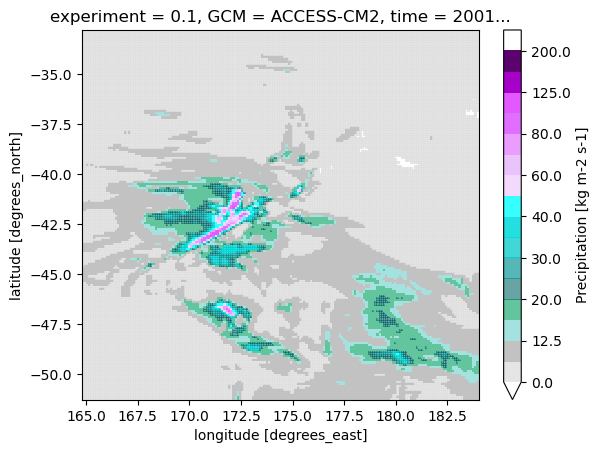

In [413]:
import matplotlib.colors as mcolors
boundaries2 = [0, 5,12.5, 15, 20, 25,30, 35, 40, 50, 60, 70, 80, 100, 125, 150, 200, 250]
colors2 = [[0.000, 0.000, 0.000, 0.000], [0.875, 0.875, 0.875, 0.784],\
          [0.761, 0.761, 0.761, 1.000], [0.639, 0.886, 0.871, 1.000], [0.388, 0.773, 0.616, 1.000],\
          [0.000, 0.392, 0.392, 0.588], [0.000, 0.576, 0.576, 0.667], [0.000, 0.792, 0.792, 0.745],\
          [0.000, 0.855, 0.855, 0.863], [0.212, 1.000, 1.000, 1.000], [0.953, 0.855, 0.992, 1.000],\
          [0.918, 0.765, 0.992, 1.000], [0.918, 0.612, 1.000, 1.000], [0.878, 0.431, 1.000, 1.000],\
          [0.886, 0.349, 1.000, 1.000], [0.651, 0.004, 0.788, 1.000], [0.357, 0.008, 0.431, 1.000],\
          [0.180, 0.000, 0.224, 1.000]]
#reviated for clarity

# Create the colormap using ListedColormap
cmap = mcolors.ListedColormap(colors2)
norm = mcolors.BoundaryNorm(boundaries2, cmap.N)
ic_data.isel(member =0, experiment =-1).pr.isel(time =0).plot(cmap = cmap, norm = norm)

In [447]:
df2 = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/Intensity_Penalty/NorESM2-MM_Intensity_Penalty_hist_1986_2005_cascaded_perfect_applied.nc')

In [450]:
dfs = df2.sel(time = ic_data.time.to_index().intersection(df2.time.to_index()))

In [507]:
crps_ic = xs.crps_ensemble(ground_truth.sel(time = dfs.time).pr*3600*24, ic_data.sel(time = dfs.time).pr, dim ="time")
crps_no = xs.crps_ensemble(ground_truth.sel(time = dfs.time).pr*3600*24, no_cons.sel(time =dfs.time).pr, dim ="time")
crps_ec = xs.crps_ensemble(ground_truth.sel(time = dfs.time).pr*3600*24, ec_ic_trained.sel(time = dfs.time).pr, dim ="time")
crps_4ic = xs.crps_ensemble(ground_truth.sel(time = dfs.time).pr.coarsen(lat =4, lon =4, boundary ='trim').max()*3600*24,
                           ic_data.sel(time = dfs.time).pr.coarsen(lat =4, lon =4, boundary ='trim').max(), dim ="time")
crps_4no = xs.crps_ensemble(ground_truth.sel(time = dfs.time).pr.coarsen(lat =4, lon =4, boundary ='trim').max()*3600*24,
                           no_cons.sel(time = dfs.time).pr.coarsen(lat =4, lon =4, boundary ='trim').max(), dim ="time")
crps_4ec = xs.crps_ensemble(ground_truth.sel(time = dfs.time).pr.coarsen(lat =4, lon =4, boundary ='trim').max()*3600*24,
                           ec_ic_trained.sel(time = dfs.time).pr.coarsen(lat =4, lon =4, boundary ='trim').max(), dim ="time")

/nesi/project/niwa00004/rampaln/lib/python3.8/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _crps_ensemble_gufunc
  return self.ufunc(*args, **kwargs)
/nesi/project/niwa00004/rampaln/lib/python3.8/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _crps_ensemble_gufunc
  return self.ufunc(*args, **kwargs)


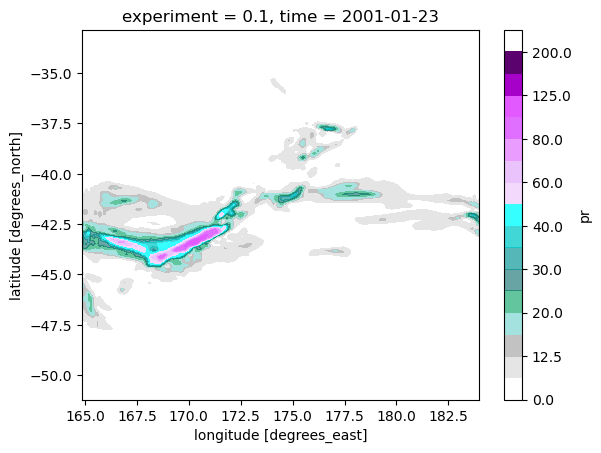

In [456]:
dfs.isel(member =1, experiment =-1).pr.isel(time =22).clip(0.0, 1000).plot.contourf(cmap = cmap, norm = norm)

In [ ]:
### Checking the CRPS

In [461]:
dfs

<xarray.Dataset>
Dimensions:     (experiment: 7, lon: 179, lat: 172, time: 1825, member: 10)
Coordinates:
  * experiment  (experiment) float64 0.0 0.0001 0.00125 0.0025 0.005 0.01 0.1
  * lon         (lon) float32 164.9 165.0 165.1 165.2 ... 183.7 183.9 184.0
  * lat         (lat) float32 -51.21 -51.11 -51.0 ... -33.07 -32.97 -32.86
  * time        (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2005-12-31
Dimensions without coordinates: member
Data variables:
    pr          (experiment, member, time, lat, lon) float32 2.8 ... 0.3692
Attributes: (12/19)
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    contact:         ccam@csiro.au
    project:         Undefined CCAM project
    history:         Created on 2022-06-28 09:55:09
    ...              ...
    ms:              6
    ntrac:           0
    nproc:           864
    procmode:        10
    decomp:          face
    modeling_realm:  atmos

In [463]:
crps_v2 = xs.crps_ensemble(ground_truth.pr.sel(time = dfs.time) * 3600*24,dfs.pr.where(dfs.pr> 0.1, 0.0), dim ="time")

In [486]:
crps_v2_max = xs.crps_ensemble(ground_truth.pr.sel(time = dfs.time).coarsen(lat =5, lon =5, boundary ='trim').max() * 3600*24,dfs.pr.where(dfs.pr> 0.1, 0.0).coarsen(lat =5, lon =5, boundary ='trim').max(), dim ="time")

In [467]:
crps_v3 = xs.crps_ensemble(ground_truth.pr.sel(time = dfs.time) * 3600*24,ic_data.sel(time = dfs.time).pr.where(ic_data.sel(time = dfs.time).pr> 0.1, 0.0), dim ="time")

In [482]:
crps_v6 = xs.crps_ensemble(ground_truth.pr.sel(time = dfs.time) * 3600*24, ic_ac_data.sel(time = dfs.time).pr.where( ic_ac_data.sel(time = dfs.time).pr> 0.1, 0.0), dim ="time")

In [489]:
dfrank_new = (dfs.pr.where(dfs.pr> 0.001, 0.0).clip(0,1000) > ground_truth.pr.sel(time = dfs.time)*3600*24).sum("member")/10.0


In [499]:
dfrank_new_old = (ic_data.sel(time = dfs.time).pr.where(ic_data.sel(time = dfs.time)> 0.001, 0.0).clip(0,1000) > ground_truth.pr.sel(time = dfs.time)*3600*24).sum("member")/10.0


In [491]:
z23 =[]
bins = np.arange(-0.005,1.1, 0.1)
for i in range(dfrank_new.experiment.size):
    z1 = binned_statistic(x =  dfrank_new.isel(experiment =i).values.ravel(),values =np.ones([1]), statistic = 'count', bins =bins)
    z23.append(z1[0])

In [501]:
z24 =[]
bins = np.arange(-0.005,1.1, 0.1)
for i in range(dfrank_new.experiment.size):
    z1 = binned_statistic(x =  dfrank_new_old.isel(experiment =i).pr.values.ravel(),values =np.ones([1]), statistic = 'count', bins =bins)
    z24.append(z1[0])

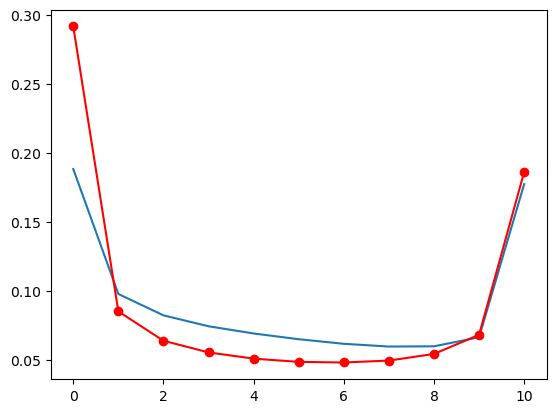

In [521]:
plt.plot(z23[-1]/sum(z23[-1]))
plt.plot(z24[-1]/sum(z24[-1]), color ='r', marker ='o')


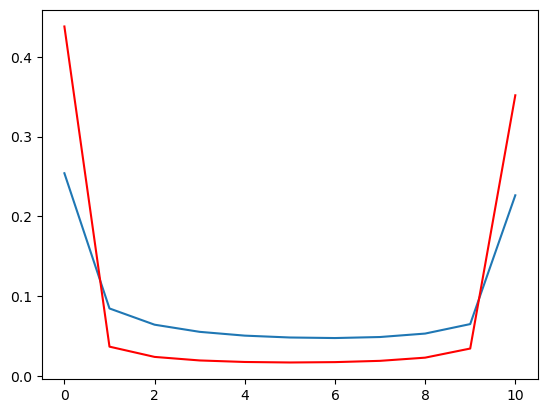

In [505]:
plt.plot(z23[-3]/sum(z23[-3]))
plt.plot(z24[-3]/sum(z24[-3]), color ='r')


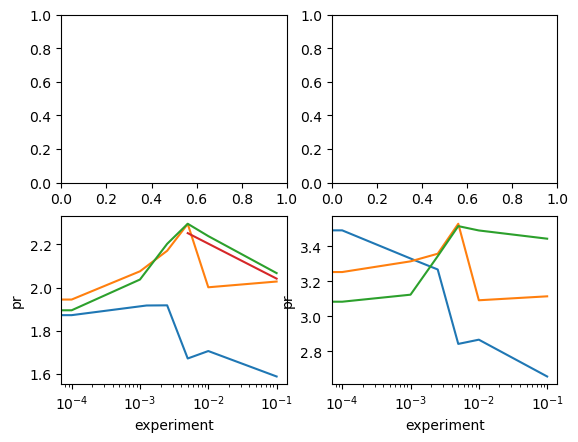

In [520]:
fig, ax = plt.subplots(2,2)
ax = ax.ravel()
crps_v2_max.mean(["lat","lon"]).plot(ax = ax[-1])
crps_4ic.mean(["lat","lon"]).plot(ax = ax[-1])
crps_4no.mean(["lat","lon"]).plot(ax = ax[-1])

crps_v2.mean(["lat","lon"]).plot(ax = ax[-2])
crps_ic.mean(["lat","lon"]).plot(ax = ax[-2])
crps_no.mean(["lat","lon"]).plot(ax = ax[-2])
crps_ec.mean(["lat","lon"]).plot(ax = ax[-2])

ax[-1].set_xscale('log')
ax[-2].set_xscale('log')

In [ ]:
# Architecture strongly affects dispersion, but no many other things
# this is indepedent of the amount of training data (

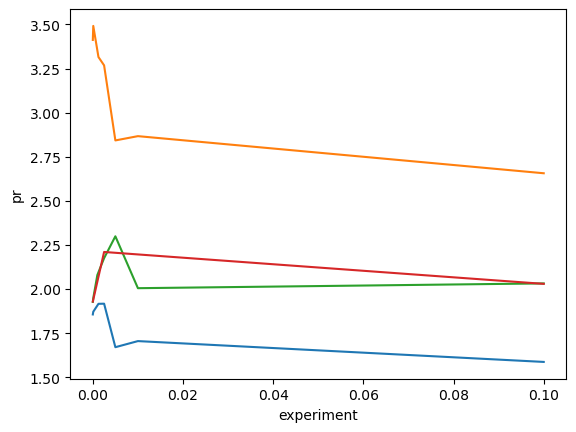

In [487]:
crps_v2.mean(["lat","lon"]).plot()
crps_v2_max.mean(["lat","lon"]).plot()
crps_v3.mean(["lat","lon"]).plot()
crps_v6.mean(["lat","lon"]).plot()


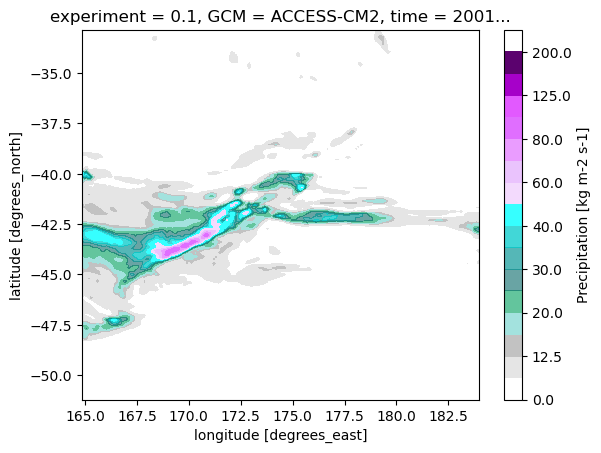

In [457]:
ic_data.isel(member =1, experiment =-1).pr.isel(time =22).clip(0.0, 1000).plot.contourf(cmap = cmap, norm = norm)

In [53]:
no_cons.isel(member =0).max(["time","lat","lon"])

<xarray.Dataset>
Dimensions:     (experiment: 7)
Coordinates:
  * experiment  (experiment) float64 0.0 0.0001 0.001 0.0025 0.005 0.01 0.1
    GCM         <U10 'ACCESS-CM2'
Data variables:
    pr          (experiment) float32 353.3 314.3 343.7 ... 2.3e+03 1.222e+04

In [342]:
mae_ic = xs.mae(ground_truth.sel(time = ic_data.time).pr*3600*24, ic_data.sel(time = ic_data.time).pr.mean("member"))
mae_no = xs.mae(ground_truth.sel(time = ic_data.time).pr*3600*24, no_cons.sel(time = ic_data.time).pr.mean("member"))
mae_ec = xs.mae(ground_truth.sel(time = ic_data.time).pr*3600*24, ec_ic_trained.sel(time = ic_data.time).pr.mean("member"))

/nesi/project/niwa00004/rampaln/lib/python3.8/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _crps_ensemble_gufunc
  return self.ufunc(*args, **kwargs)


In [344]:
crps_4ic = xs.crps_ensemble(ground_truth.sel(time = ic_data.time).pr.coarsen(lat =4, lon =4, boundary ='trim').max()*3600*24,
                           ic_data.sel(time = ic_data.time).pr.coarsen(lat =4, lon =4, boundary ='trim').max(), dim ="time")
crps_4no = xs.crps_ensemble(ground_truth.sel(time = ic_data.time).pr.coarsen(lat =4, lon =4, boundary ='trim').max()*3600*24,
                           no_cons.sel(time = ic_data.time).pr.coarsen(lat =4, lon =4, boundary ='trim').max(), dim ="time")
crps_4ec = xs.crps_ensemble(ground_truth.sel(time = ic_data.time).pr.coarsen(lat =4, lon =4, boundary ='trim').max()*3600*24,
                           ec_ic_trained.sel(time = ic_data.time).pr.coarsen(lat =4, lon =4, boundary ='trim').max(), dim ="time")

/nesi/project/niwa00004/rampaln/lib/python3.8/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _crps_ensemble_gufunc
  return self.ufunc(*args, **kwargs)


In [409]:
ic_data.isel(time 

<xarray.Dataset>
Dimensions:     (experiment: 7, member: 10, time: 5110, lat: 172, lon: 179)
Coordinates:
  * experiment  (experiment) float64 0.0 0.0001 0.001 0.0025 0.005 0.01 0.1
  * lon         (lon) float32 164.9 165.0 165.1 165.2 ... 183.7 183.9 184.0
  * lat         (lat) float32 -51.21 -51.11 -51.0 ... -33.07 -32.97 -32.86
    GCM         <U10 'ACCESS-CM2'
  * time        (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2014-12-31
Dimensions without coordinates: member
Data variables:
    pr          (experiment, member, time, lat, lon) float32 3.182 ... 0.03103
Attributes: (12/28)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    history:         Tue Mar 12 14:54:26 2024: cdo merge /nesi/project/niwa00...
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    il:              288
    ...              ...
    BC_version:      no output bias correction
    CMOR_v:          v1.0 Public
    CDO_call:        daymean computed on hourly data
    project:         NIWA CMIP6 Downscaling
    contact:         Peter Gibson (peter.gibson@niwa.co.nz)
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....

In [345]:
crps_ic.to_netcdf(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/crps_outputs/itensity_constrainted_{gcm}.nc')

In [350]:
crps_4ic.to_netcdf(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/crps_outputs/itensity_constrainted_{gcm}_pooled.nc')

In [348]:
crps_4ec.to_netcdf(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/crps_outputs/itensity_constrainted_ec_{gcm}_pooled.nc')

In [349]:
crps_4no.to_netcdf(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/crps_outputs/No_cons_{gcm}_pooled.nc')

In [346]:
crps_no.to_netcdf(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/crps_outputs/No_cons_{gcm}.nc')

In [347]:
crps_ec.to_netcdf(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/crps_outputs/itensity_constrainted_ec_{gcm}.nc')

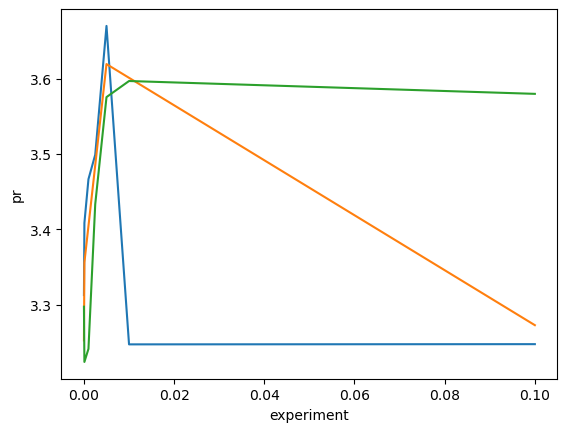

In [408]:
crps_4ic.mean(["lat","lon"]).plot()
crps_4ec.where(crps_4ec< 20, np.nan).mean(["lat","lon"]).plot()
crps_4no.where(crps_4no< 10, np.nan).mean(["lat","lon"]).plot()
#plt.xscale('log')

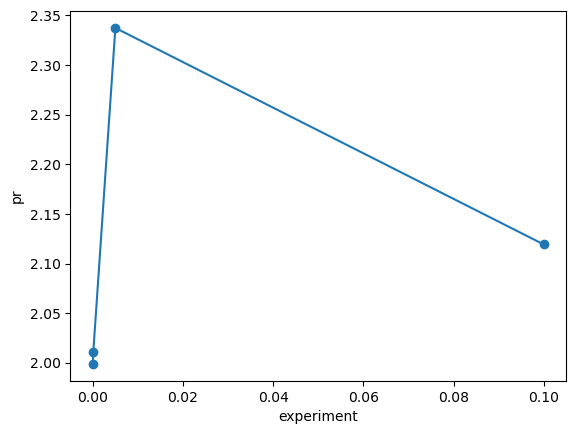

In [399]:
crps_ec.where(crps_ec< 50, np.nan).mean(["lat","lon"]).plot(marker ='o')

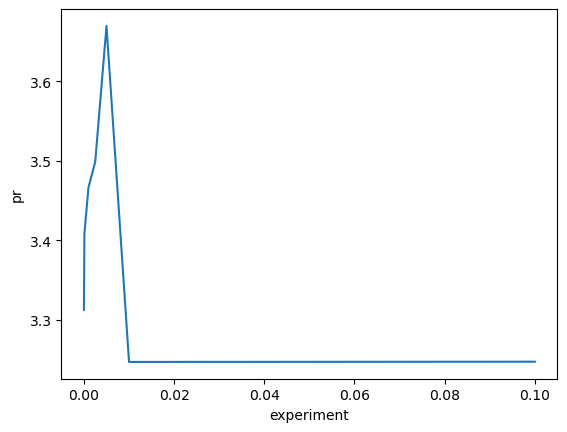

In [378]:
crps_4ic.mean(["lat","lon"]).plot()

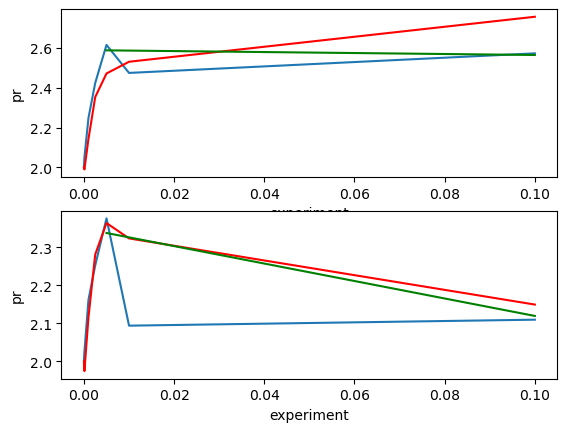

In [373]:
fig, ax = plt.subplots(2, 1)
mae_ic.plot(ax = ax[0])
mae_no.plot(color ='r',ax = ax[0])
mae_ec.plot(color ='g',ax = ax[0])
#ax[0].set_xscale('log')

crps_ic.mean(["lat","lon"]).plot(ax = ax[1])
crps_no.mean(["lat","lon"]).plot(color ='r',ax = ax[1])
crps_ec.mean(["lat","lon"]).plot(color ='g',ax = ax[1])
#ax[1].set_xscale('log')

In [14]:
mae = xs.mae(ground_truth.sel(time = common_times).pr*3600*24, ic_data.sel(time = common_times).pr.mean("member"))

In [15]:
mae = abs(ground_truth.sel(time = common_times[0:50]).pr*3600*24 - no_cons.sel(time = common_times[0:50]).mean("member"))

In [21]:
crps = xs.crps_ensemble(ground_truth.sel(time = common_times[0:50]).pr.coarsen(lat =5, lon =5, boundary ='trim').max()*3600*24, ic_data.sel(time = common_times[0:50]).pr.coarsen(lat =5, lon =5, boundary ='trim').max(), member_dim="member", dim ="time")

In [22]:
with ProgressBar():
    crps = crps.load()

[########################################] | 100% Completed | 34.8s


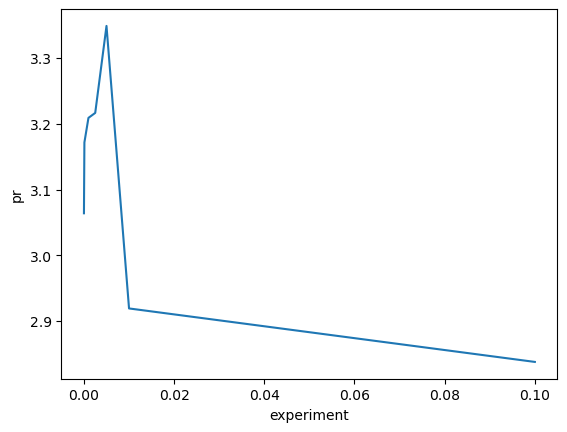

In [27]:
#mae.mean(["lat","lon","time"]).pr.plot()
crps.mean(["lat","lon"]).plot()

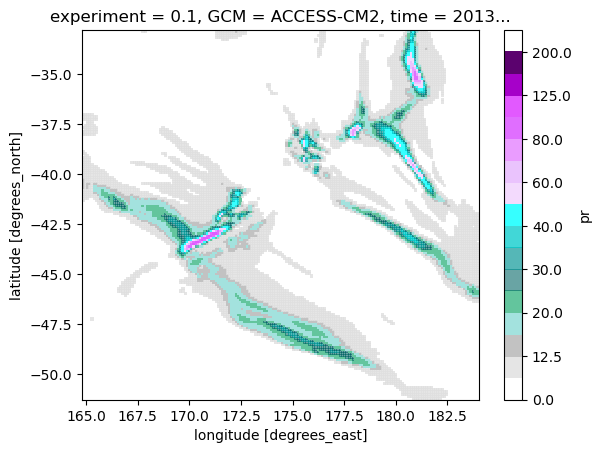

In [238]:
ic_data.sel(time = common_times[0:50]).isel(time = 15, experiment =-1).mean("member").pr.plot(cmap = cmap, norm = norm)

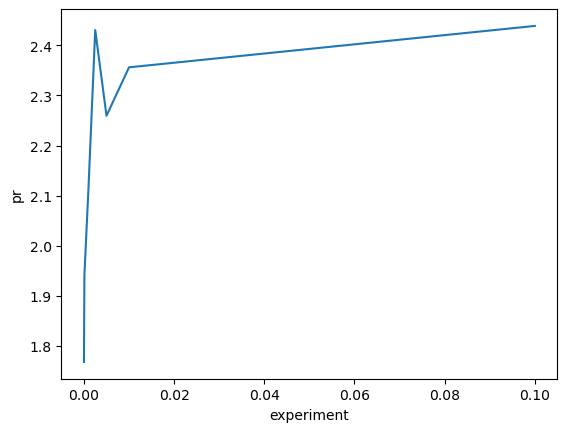

In [230]:
mae.plot()

In [469]:
df3 = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/outputs/future_run_precip_residual_new_unet_shuffle_off_new_iten_weight_new_padding_new_unet_V2_resid_now_001_iten_v4_ACCESS-CM2/CCAM_NIWA-REMS_NorESM2-MM_hist_ssp370_pr_ens_test_sample.nc')

In [475]:
df4 = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/outputs/future_run_precip_residual_new_unet_shuffle_off_new_iten_weight_new_padding_new_unet_V2_resid_now_001_iten_v4_ACCESS-CM2/CCAM_NIWA-REMS_NorESM2-MM_hist_ssp370_pr_unet_test_sample.nc')

In [476]:
df4

<xarray.Dataset>
Dimensions:  (member: 1, time: 730, lat: 172, lon: 179)
Coordinates:
  * lon      (lon) float32 164.9 165.0 165.1 165.2 ... 183.6 183.7 183.9 184.0
  * lat      (lat) float32 -51.21 -51.11 -51.0 -50.89 ... -33.07 -32.97 -32.86
    GCM      object ...
  * time     (time) datetime64[ns] 2098-01-01 2098-01-02 ... 2099-12-31
Dimensions without coordinates: member
Data variables:
    pr       (member, time, lat, lon) float32 ...
Attributes: (12/28)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    history:         Tue Mar 12 14:54:26 2024: cdo merge /nesi/project/niwa00...
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    il:              288
    ...              ...
    BC_version:      no output bias correction
    CMOR_v:          v1.0 Public
    CDO_call:        daymean computed on hourly data
    project:         NIWA CMIP6 Downscaling
    contact:         Peter Gibson (peter.gibson@niwa.co.nz)
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....

In [472]:
ground_truth_v2 = xr.open_dataset(r"/nesi/project/niwa00018/ML_downscaling_CCAM/multi-variate-gan/inputs/target_fields/target_fields_hist_ssp370_concat.nc").sel(GCM = gcm)
ground_truth_v2['time'] = pd.to_datetime(ground_truth_v2.time.dt.strftime("%Y-%m-%d"))
common_times = ground_truth_v2.time.to_index().intersection(df3.time.to_index())
with ProgressBar():
    ground_truth_v2 = ground_truth_v2.sel(time = common_times).load()

In [473]:
crps_v4 = xs.crps_ensemble(ground_truth_v2.sel(time = df3.time).pr*3600*24, df3.sel(time = df3.time).pr, dim ="time")

In [477]:
crps_v5 = xs.crps_ensemble(ground_truth_v2.sel(time = df3.time).pr*3600*24, df4.sel(time = df4.time).pr, dim ="time")

In [474]:
crps_v4.mean()

<xarray.DataArray 'pr' ()>
array(2.01659242)

In [478]:
crps_v5.mean()

<xarray.DataArray 'pr' ()>
array(1.86856633)

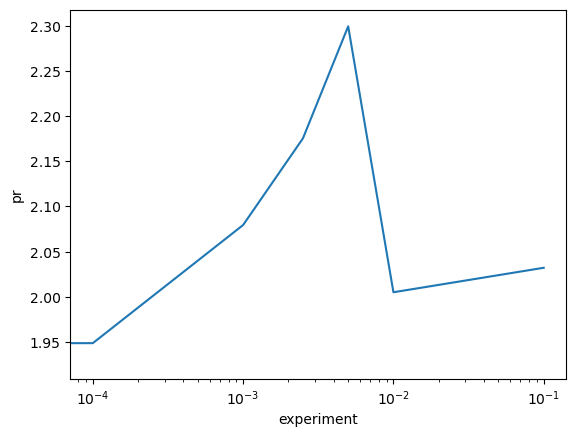

In [481]:
crps_v3.mean(["lat","lon"]).plot()
plt.xscale('log')

In [316]:
z1= (ic_data.pr.max("member") - ic_data.pr.min("member")).mean(["time","lat","lon"])

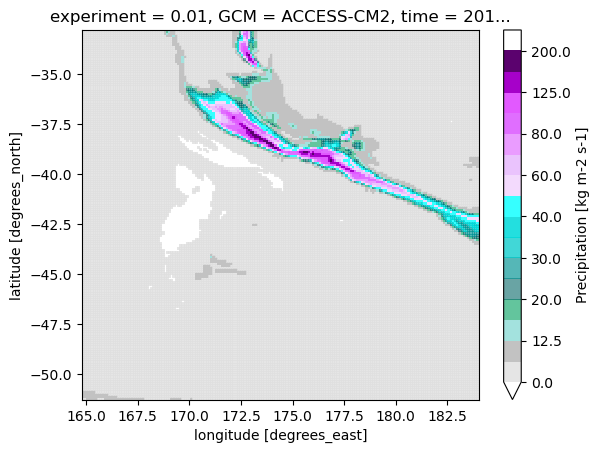

In [314]:
ic_data.pr.isel(experiment =-2).isel(time =17, member =5).plot(cmap =cmap, norm = norm)

In [287]:
ic_data.isel(experiment =-1, time =17).sel(lat =slice(-39.75, -39.5), lon = slice(176.25,176.5))

<xarray.Dataset>
Dimensions:     (member: 50, lat: 3, lon: 2)
Coordinates:
    experiment  float64 0.1
  * lon         (lon) float32 176.3 176.5
  * lat         (lat) float32 -39.73 -39.62 -39.51
    GCM         <U10 'ACCESS-CM2'
    time        datetime64[ns] 2013-01-18
Dimensions without coordinates: member
Data variables:
    pr          (member, lat, lon) float32 ...
Attributes: (12/28)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    history:         Tue Mar 12 14:54:26 2024: cdo merge /nesi/project/niwa00...
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    il:              288
    ...              ...
    BC_version:      no output bias correction
    CMOR_v:          v1.0 Public
    CDO_call:        daymean computed on hourly data
    project:         NIWA CMIP6 Downscaling
    contact:         Peter Gibson (peter.gibson@niwa.co.nz)
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....

/nesi/project/niwa00004/rampaln/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/nesi/project/niwa00004/rampaln/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


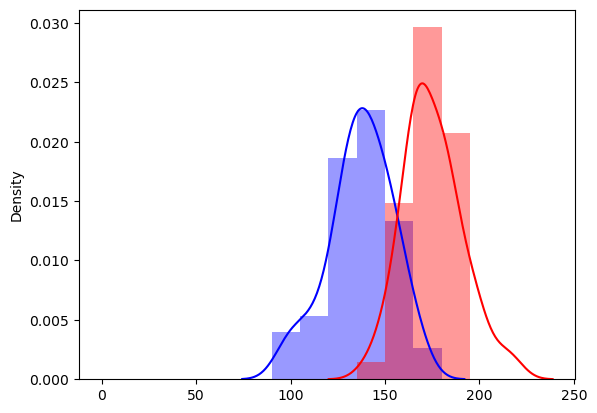

In [311]:
import seaborn
sns.distplot(ic_data.isel(experiment =-1, time =17).sel(lat =slice(-39.75, -39), lon = slice(176.25,176.35)).max(["lat","lon"]).pr.values.ravel(), bins =np.arange(0,200,15), color ='b')
sns.distplot(ic_data.isel(experiment =5, time =17).sel(lat =slice(-39.75, -39), lon = slice(176.25,177.35)).max(["lat","lon"]).pr.values.ravel(), bins =np.arange(0,200,15), color ='r')

In [58]:
import matplotlib.colors as mcolors
boundaries2 = [0, 5,12.5, 15, 20, 25,30, 35, 40, 50, 60, 70, 80, 100, 125, 150, 200, 250]
colors2 = [[0.000, 0.000, 0.000, 0.000], [0.875, 0.875, 0.875, 0.784],\
          [0.761, 0.761, 0.761, 1.000], [0.639, 0.886, 0.871, 1.000], [0.388, 0.773, 0.616, 1.000],\
          [0.000, 0.392, 0.392, 0.588], [0.000, 0.576, 0.576, 0.667], [0.000, 0.792, 0.792, 0.745],\
          [0.000, 0.855, 0.855, 0.863], [0.212, 1.000, 1.000, 1.000], [0.953, 0.855, 0.992, 1.000],\
          [0.918, 0.765, 0.992, 1.000], [0.918, 0.612, 1.000, 1.000], [0.878, 0.431, 1.000, 1.000],\
          [0.886, 0.349, 1.000, 1.000], [0.651, 0.004, 0.788, 1.000], [0.357, 0.008, 0.431, 1.000],\
          [0.180, 0.000, 0.224, 1.000]]
#reviated for clarity

# Create the colormap using ListedColormap
cmap = mcolors.ListedColormap(colors2)
norm = mcolors.BoundaryNorm(boundaries2, cmap.N)

In [5]:
climo = no_cons.isel(member = slice(0,1)).groupby('time.season').mean(["time","member"])




In [9]:
climo_v2 = ic_data.isel(member = slice(0,1)).groupby('time.season').mean(["time","member"])




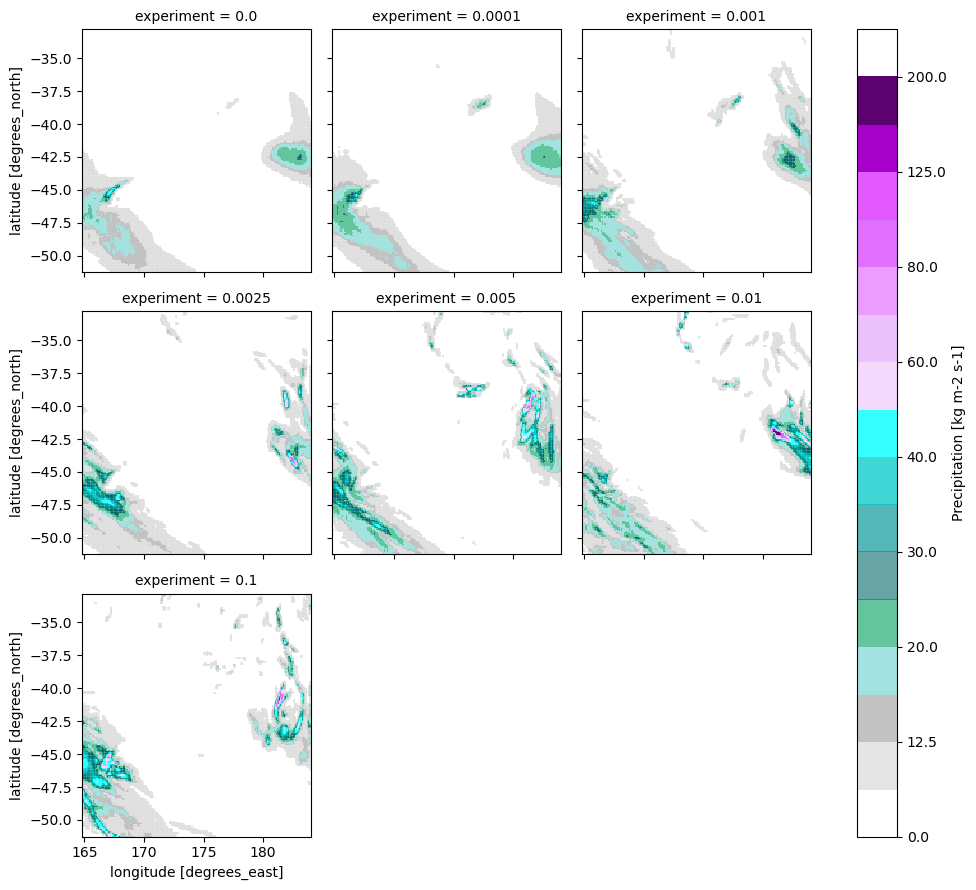

In [59]:
no_cons.sel(time ="2014-03-26").isel(member =0).clip(0.5, 1000).pr.plot(col="experiment", col_wrap =3, cmap = cmap, norm = norm, vmin =0)

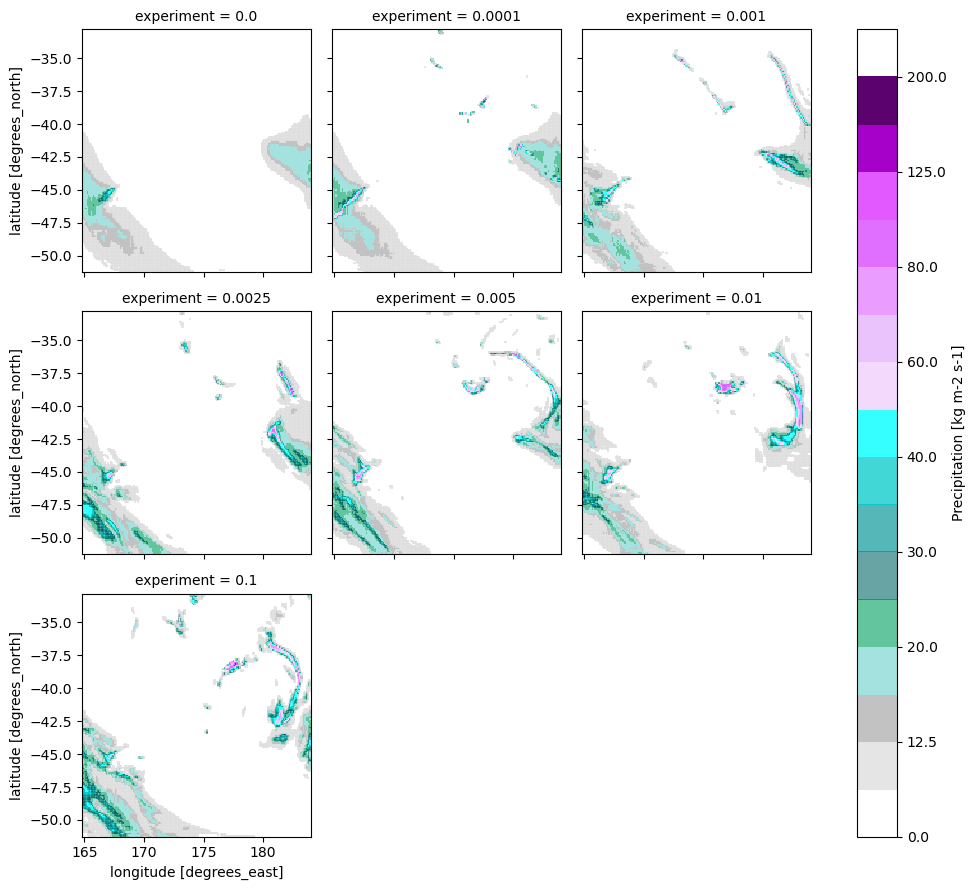

In [60]:
ic_data.sel(time ="2014-03-26").isel(member =0).clip(0.5, 1000).pr.plot(col="experiment", col_wrap =3, cmap = cmap, norm = norm, vmin =0)

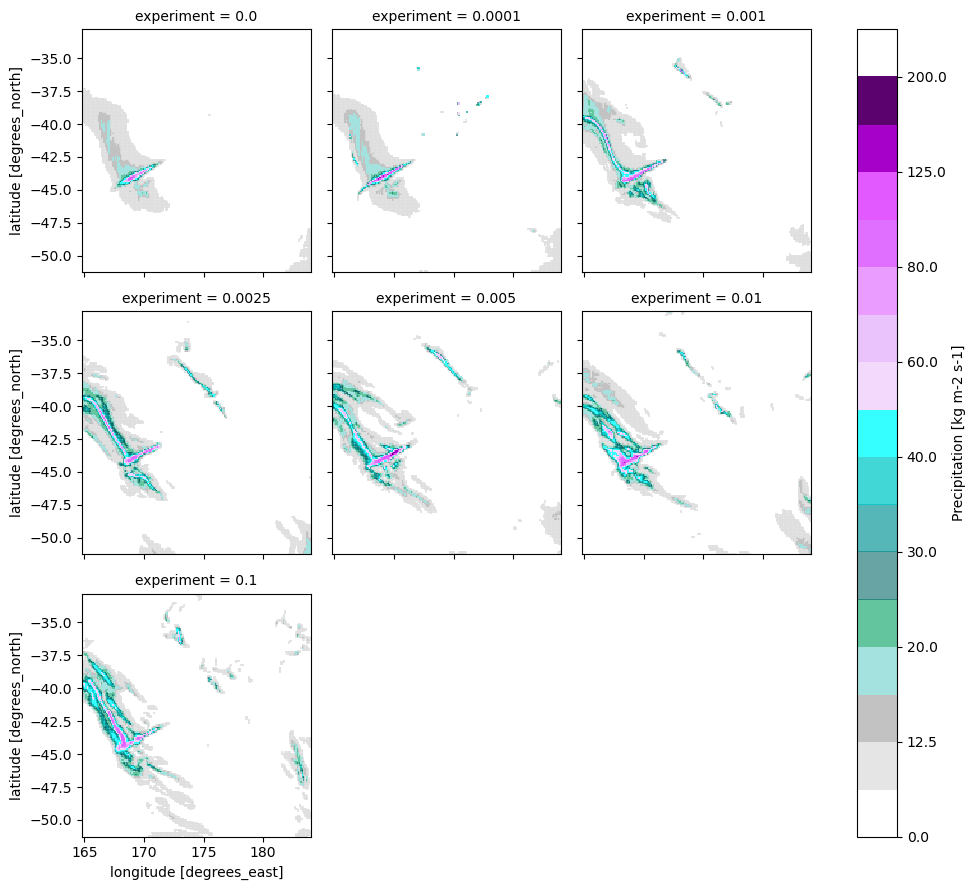

In [63]:

ic_data.sel(time ="2014-03-27").isel(member =0).clip(0.5, 1000).pr.plot(col="experiment", col_wrap =3, cmap = cmap, norm = norm, vmin =0)

In [89]:
import seaborn as sns
bins= np.arange(1, 1000, 25)

In [90]:
counts_true = binned_statistic(x =  ground_truth.pr.values.ravel()*3600*24,values =ground_truth.pr.values.ravel(), statistic = 'count', bins =bins)

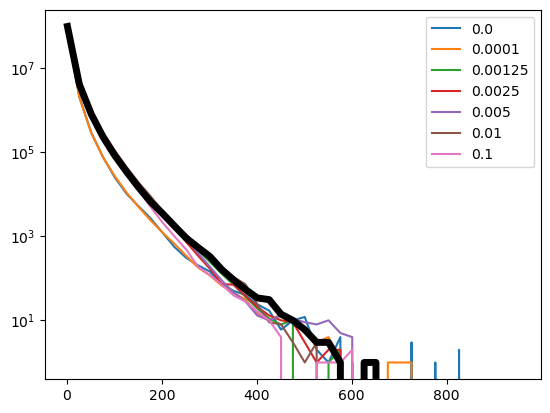

In [76]:
counted = []
fig, ax = plt.subplots()
for i in range(7):
    counts = binned_statistic(x = df.isel(experiment =i, member =0).pr.values.ravel(),values =df.isel(experiment =i, member =0).pr.values.ravel(), statistic = 'count', bins =bins)
    counted.append(counts[0])
    ax.plot(bins[:-1], counts[0], label =f'{df.experiment.values[i]}')
ax.plot(bins[:-1], counts_true[0], color ='k', lw =5)

ax.set_yscale('log')
ax.legend()

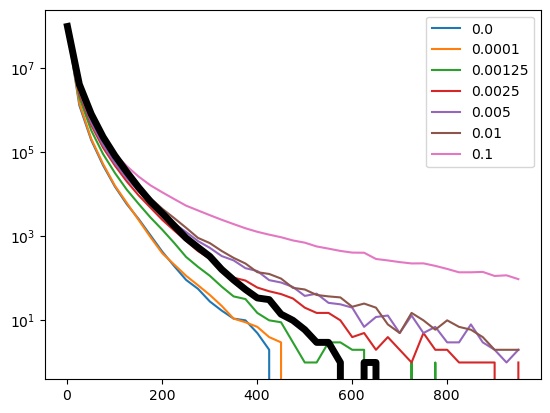

In [75]:
counted2 = []
fig, ax = plt.subplots()
for i in range(7):
    counts = binned_statistic(x =  df2.isel(experiment =i, member =0).pr.values.ravel(),values =df2.isel(experiment =i, member =0).pr.values.ravel(), statistic = 'count', bins =bins)[0]
    counted2.append(counts)
    ax.plot(bins[:-1], counts, label =f'{df2.experiment.values[i]}')
ax.plot(bins[:-1], counts_true[0], color ='k', lw =5)
ax.set_yscale('log')
ax.legend()

In [77]:
counted = np.array(counted)

In [78]:
counted2 = np.array(counted2)

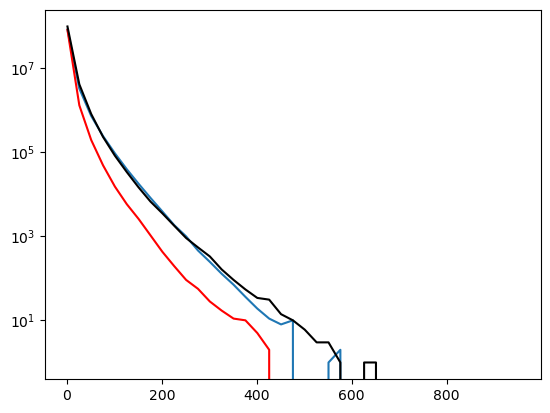

In [117]:
plt.plot(bins[:-1], (counted[-5]))
plt.plot(bins[:-1],counted2[0], color='r')
plt.plot(bins[:-1],counts_true[0], color='k')

plt.yscale('log')

In [185]:
(np.log(counts_true[0]/(counted+0.0001)+0.0001))

array([[ 1.28800078e-01,  2.19022645e-01,  3.85781879e-01,
         5.54713174e-01,  6.96683107e-01,  8.52663302e-01,
         1.02630774e+00,  1.22137869e+00,  1.32951054e+00,
         1.40378967e+00,  1.43045888e+00,  1.46567458e+00,
         1.53467926e+00,  1.57609009e+00,  1.61781428e+00,
         1.58763503e+00,  1.69259514e+00,  1.75226644e+00,
         1.85190398e+00,  1.84994560e+00,  1.87827854e+00,
         1.91483396e+00,  1.99040298e+00,  1.98258084e+00,
         1.90042234e+00,  1.99053131e+00,  2.18721296e+00,
         2.28047595e+00,  2.62855413e+00,  2.25130024e+00,
         2.82551270e+00,  2.78501242e+00,  3.06625939e+00,
         2.35388262e+00,  2.22605055e+00,  2.36528720e+00,
         2.49182704e+00,  2.63905197e+00,  2.44716386e+00,
         2.24248346e+00,  1.96009887e+00,  2.18605251e+00,
         1.62471739e+00,  2.58020441e+00,  1.94591015e+00,
         2.70802354e+00,  2.14005293e+00,  2.27725254e+00,
         3.33210809e+00,  2.19720236e+00,  2.77254497e+0

In [30]:
lams = df.experiment.values

In [130]:
bins[:18]

array([  1,  26,  51,  76, 101, 126, 151, 176, 201, 226, 251, 276, 301,
       326, 351, 376, 401, 426])

/tmp/ipykernel_47220/1875927037.py:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(lams[:], (np.mean((abs(np.log(counts_true[0]/(counted))))[:,:18], axis =1)))
/tmp/ipykernel_47220/1875927037.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(lams[:], (np.mean((abs(np.log(counts_true[0]/(counted))))[:,:18], axis =1)))
/tmp/ipykernel_47220/1875927037.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(lams[:], (np.mean((abs(np.log(counts_true[0]/(counted))))[:,:18], axis =1)))
/tmp/ipykernel_47220/1875927037.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(lams[:], (np.mean((abs(np.log(counts_true[0]/(counted2))))[:,:18], axis =1)), color ='r')
/tmp/ipykernel_47220/1875927037.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(lams[:], (np.mean((abs(np.log(counts_true[0]/(counted2))))[:,:18], axis =1)), color ='r')
/tmp/ipykernel_47220/1875927037.py:2: RuntimeWarning: divide by 

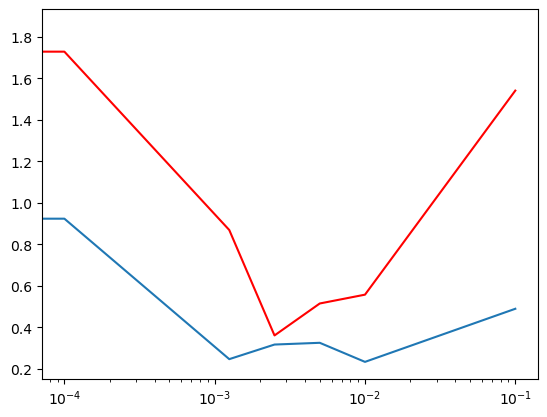

In [132]:
plt.plot(lams[:], (np.mean((abs(np.log(counts_true[0]/(counted))))[:,:18], axis =1)))
plt.plot(lams[:], (np.mean((abs(np.log(counts_true[0]/(counted2))))[:,:18], axis =1)), color ='r')
#plt.axhline((np.mean((abs(np.log(counts_true[0]/(counted2+0.0001)+0.0001)))[0:1,:], axis =1)))
#plt.axhline((np.mean((abs(np.log(counts_true[0]/(counted+0.0001)+0.0001)))[0:1,:], axis =1)))
plt.xscale('log')
#ax.set_xlim(1e-5, 1)

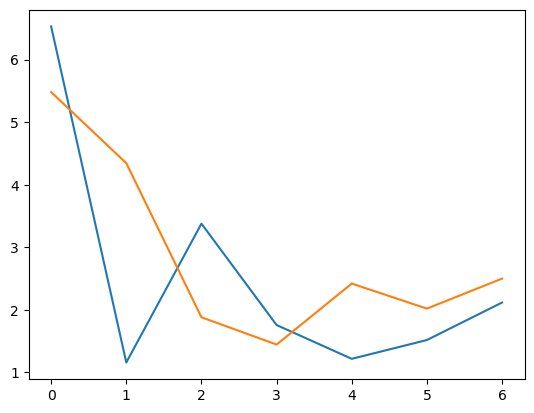

In [156]:
plt.plot(abs(np.log(counts_true[0]/(counted2+0.0001)+0.0001)).mean(1))
plt.plot(abs(np.log(counts_true[0]/(counted+0.0001)+0.0001)).mean(1))

In [133]:
import matplotlib

In [158]:
counts_true[0]/(counted+0.0001)

array([[1.15637971e+00, 1.55533274e+00, 2.12661238e+00, 3.00799999e+00,
        3.89729512e+00, 4.24304226e+00, 4.72473470e+00, 4.97463868e+00,
        5.57839304e+00, 6.36626683e+00, 6.65230667e+00, 7.29323125e+00,
        6.95104652e+00, 9.30281035e+00, 1.15056050e+01, 1.65581010e+01,
        1.49687032e+01, 9.91663912e+00, 1.28499358e+01, 1.03332841e+01,
        7.99996000e+00, 7.33329259e+00, 9.39990600e+00, 9.12488594e+00,
        1.37496563e+01, 2.84985751e+01, 3.29967003e+01, 2.70000000e+05,
        2.60000000e+05, 1.70000000e+05, 1.20000000e+05, 1.40000000e+05,
        1.10000000e+05, 7.00000000e+04, 9.99900010e-01, 3.00000000e+04,
        1.00000000e+04, 1.00000000e+04, 4.00000000e+04, 2.00000000e+04,
        1.00000000e+04, 1.00000000e+04, 1.00000000e+04, 0.00000000e+00,
        1.00000000e+04, 0.00000000e+00, 1.00000000e+04, 0.00000000e+00,
        0.00000000e+00],
       [1.16327867e+00, 1.49345275e+00, 1.95249145e+00, 2.57658165e+00,
        2.90928733e+00, 3.05269623e+00,

In [159]:
np.log(np.array(counts_true[0])+0.001) - np.log(counted+0.001)

array([[ 1.45294188e-01,  4.41689501e-01,  7.54530280e-01,
         1.10127539e+00,  1.36028272e+00,  1.44528046e+00,
         1.55281128e+00,  1.60435252e+00,  1.71890035e+00,
         1.85101250e+00,  1.89496251e+00,  1.98694478e+00,
         1.93888958e+00,  2.23031096e+00,  2.44282518e+00,
         2.80685594e+00,  2.70593553e+00,  2.29419187e+00,
         2.55329770e+00,  2.33533191e+00,  2.07939779e+00,
         1.99238219e+00,  2.24062033e+00,  2.21090661e+00,
         2.62080704e+00,  3.34942176e+00,  3.49553836e+00,
         1.02036292e+01,  1.01658903e+01,  9.74102744e+00,
         9.39274526e+00,  9.54688403e+00,  9.30574146e+00,
         8.85380827e+00,  0.00000000e+00,  8.00670085e+00,
         6.90875478e+00,  6.90875478e+00,  8.29429961e+00,
         7.60140233e+00,  6.90875478e+00,  6.90875478e+00,
         6.90875478e+00,  0.00000000e+00,  6.90875478e+00,
         0.00000000e+00,  6.90875478e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.51242460e-01,  4.01

In [160]:
error2 = np.sqrt(abs(np.log(np.array(counts_true[0])+0.001) -np.log(counted2+0.001))**2)

In [161]:
error = np.sqrt(abs(np.log(np.array(counts_true[0])+0.001) -np.log(counted+0.001))**2)

In [162]:
np.log(counted2+0.001)[-1]

array([ 1.57326823e+01,  1.39689461e+01,  1.29702811e+01,  1.21445685e+01,
        1.14444967e+01,  1.08314302e+01,  1.02996967e+01,  9.81029718e+00,
        9.35095421e+00,  8.90275500e+00,  8.49400665e+00,  8.06325218e+00,
        7.59367692e+00,  7.16981257e+00,  6.74075692e+00,  6.34388219e+00,
        5.93912070e+00,  5.67675723e+00,  5.35847600e+00,  5.08636719e+00,
        4.86136933e+00,  4.50425533e+00,  4.24277894e+00,  4.00005220e+00,
        3.68890445e+00,  3.18639395e+00,  2.91240501e+00,  2.77265122e+00,
        2.36094834e+00,  1.48183179e+00,  1.48183179e+00,  1.02997650e+00,
        1.09894557e+00,  7.88911803e-01, -5.09160344e-01,  1.83154543e-01,
        9.99500333e-04, -6.90775528e+00, -1.60445037e+00, -6.90775528e+00,
       -6.90775528e+00, -9.13793852e-01, -9.13793852e-01, -6.90775528e+00,
       -6.90775528e+00, -6.90775528e+00, -6.90775528e+00, -6.90775528e+00,
       -6.90775528e+00])

In [163]:
error.mean(1)

array([3.93117268, 2.98309136, 1.52078818, 1.35340969, 2.52493009,
       2.04982957, 2.64540253])

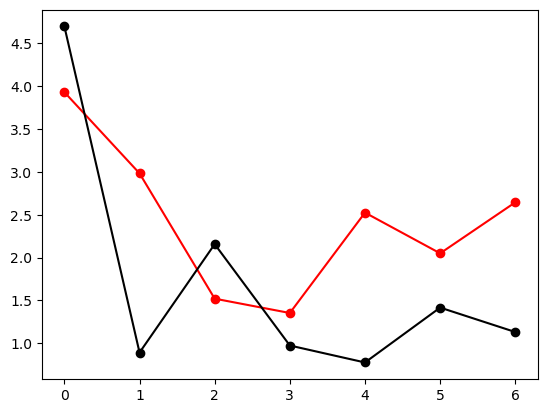

In [164]:
plt.plot(error.mean(1), 'ro-')
plt.plot(error2.mean(1), 'ko-')

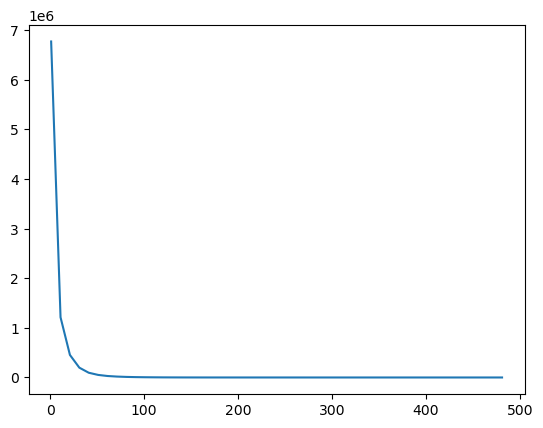

In [165]:

plt.plot(bins[:-1],counts[0])
#plt.yscale('log')

In [166]:
counts

array([[6.767419e+06, 1.212247e+06, 4.538220e+05, 1.978200e+05,
        9.555600e+04, 5.159900e+04, 2.978100e+04, 1.832000e+04,
        1.142800e+04, 7.299000e+03, 4.803000e+03, 3.160000e+03,
        1.957000e+03, 1.304000e+03, 7.990000e+02, 5.630000e+02,
        3.810000e+02, 2.470000e+02, 2.140000e+02, 1.390000e+02,
        1.150000e+02, 9.500000e+01, 6.300000e+01, 4.800000e+01,
        4.500000e+01, 2.400000e+01, 2.000000e+01, 1.100000e+01,
        1.100000e+01, 1.000000e+00, 4.000000e+00, 1.000000e+00,
        0.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       [6.812206e+06, 1.180442e+06, 4.318870e+05, 1.893700e+05,
        9.401500e+04, 5.104000e+04, 3.030200e+04, 1.843100e+04,
        1.153900e+04, 7.459000e+03, 4.801000e+03, 2.963000e+03,
        1.802000e

In [167]:
counts[0]

array([6.767419e+06, 1.212247e+06, 4.538220e+05, 1.978200e+05,
       9.555600e+04, 5.159900e+04, 2.978100e+04, 1.832000e+04,
       1.142800e+04, 7.299000e+03, 4.803000e+03, 3.160000e+03,
       1.957000e+03, 1.304000e+03, 7.990000e+02, 5.630000e+02,
       3.810000e+02, 2.470000e+02, 2.140000e+02, 1.390000e+02,
       1.150000e+02, 9.500000e+01, 6.300000e+01, 4.800000e+01,
       4.500000e+01, 2.400000e+01, 2.000000e+01, 1.100000e+01,
       1.100000e+01, 1.000000e+00, 4.000000e+00, 1.000000e+00,
       0.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00])

In [168]:
def f(x)

SyntaxError: invalid syntax (750126819.py, line 1)

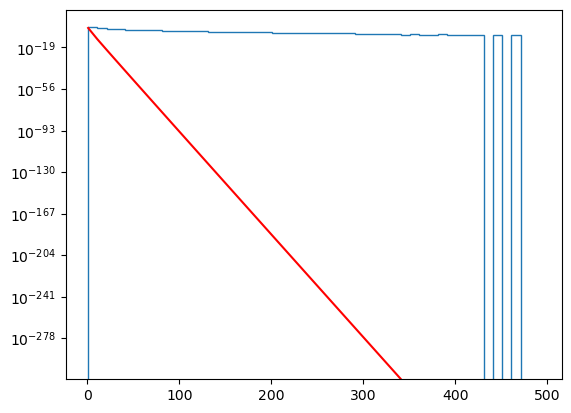

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

gamma = stats.gamma
# a, loc, scale = 3, 0, 2
# size = 20000
# y = gamma.rvs(a, loc, scale, size=size)

# x = np.linspace(0, y.max(), 100)
# fit
param = gamma.fit(counts[0]/sum(counts[0]))
pdf_fitted = gamma.pdf(bins, *param)
plt.plot(bins, pdf_fitted, color='r')

# # plot the histogram
plt.hist(ground_truth.pr.values.ravel()*3600*24, bins = bins, density=True, histtype='step')
plt.yscale('log')
# plt.show()

In [ ]:
counts[0]

array([8.004709e+06, 1.040838e+06, 3.567690e+05, 1.552880e+05,
       7.809400e+04, 4.223100e+04, 2.538600e+04, 1.549600e+04,
       1.006900e+04, 6.379000e+03, 4.324000e+03, 2.910000e+03,
       1.988000e+03, 1.321000e+03, 1.024000e+03, 7.120000e+02,
       4.790000e+02, 3.570000e+02, 2.570000e+02, 2.170000e+02,
       1.600000e+02, 1.320000e+02, 9.400000e+01, 7.300000e+01,
       5.500000e+01, 5.700000e+01, 3.300000e+01, 2.700000e+01,
       2.600000e+01, 1.700000e+01, 1.200000e+01, 1.400000e+01,
       1.100000e+01, 7.000000e+00, 1.000000e+00, 3.000000e+00,
       1.000000e+00, 1.000000e+00, 4.000000e+00, 2.000000e+00,
       1.000000e+00, 1.000000e+00, 1.000000e+00, 0.000000e+00,
       1.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
       0.000000e+00])

In [ ]:
counts[0][0]/sum(counts[0])

0.8210309097322419

In [ ]:
# dfrank_ic_ac = (ic_ac_data.pr.sel(time = common_times).where(ic_ac_data .pr.sel(time = common_times)> 0.001, 0.0).clip(0,1000) > ground_truth.pr.sel(time = common_times)*3600*24).sum("member")/50.0
# dfrank= (no_cons.pr.sel(time = common_times).where(no_cons.pr.sel(time = common_times)> 0.001, 0.0).clip(0,1000) > ground_truth.pr.sel(time = common_times)*3600*24).sum("member")/50.0
# dfrank_ec_ic= (ec_ic_trained.pr.sel(time = common_times).where(ec_ic_trained.pr.sel(time = common_times)> 0.001, 0.0).clip(0,1000) > ground_truth.pr.sel(time = common_times)*3600*24).sum("member")/50.0
# dfrank_ic = (ic_data.pr.sel(time = common_times).where(ic_data .pr.sel(time = common_times)> 0.001, 0.0).clip(0,1000) > ground_truth.pr.sel(time = common_times)*3600*24).sum("member")/50.0

In [338]:
dfrank.to_netcdf(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/Rank_histogram_raw_Nocons_{gcm}.nc')
dfrank_ec_ic.to_netcdf(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/Rank_histogram_raw_EC_trained_IC_used_{gcm}.nc')
dfrank_ic_ac.to_netcdf('/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/Rank_histogram_raw_Intensity_Con_Average_{gcm}.nc')
dfrank_ic.to_netcdf(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/Rank_histogram_raw_Intensity_Constrained_{gcm}.nc')

In [ ]:
# the below plot shows how to compute the rank histograms on extreme events explicitly. 

In [ ]:
ground_truth.sel(time = common_times)

<xarray.Dataset>
Dimensions:     (time: 730, bnds: 2, lon: 179, lat: 172)
Coordinates:
  * time        (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2014-12-31
  * lon         (lon) float32 164.9 165.0 165.1 165.2 ... 183.7 183.9 184.0
  * lat         (lat) float32 -51.21 -51.11 -51.0 ... -33.07 -32.97 -32.86
    GCM         <U10 'NorESM2-MM'
Dimensions without coordinates: bnds
Data variables:
    time_bnds   (time, bnds) object ...
    lon_bnds    (lon, bnds) float32 ...
    lat_bnds    (lat, bnds) float32 ...
    pr          (time, lat, lon) float32 ...
    psl         (time, lat, lon) float32 ...
    sfcWind     (time, lat, lon) float32 ...
    sfcWindmax  (time, lat, lon) float32 ...
    tasmax      (time, lat, lon) float32 ...
    tasmin      (time, lat, lon) float32 ...
Attributes: (12/28)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    history:         Tue Mar 12 14:54:26 2024: cdo merge /nesi/project/niwa00...
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    il:              288
    ...              ...
    BC_version:      no output bias correction
    CMOR_v:          v1.0 Public
    CDO_call:        daymean computed on hourly data
    project:         NIWA CMIP6 Downscaling
    contact:         Peter Gibson (peter.gibson@niwa.co.nz)
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....

In [292]:
true_quantile =  (ground_truth.sel(time = common_times).pr*3600*24).where(ground_truth.sel(time = common_times).pr*3600*24 >1, np.nan).quantile(q = 0.9, dim ="time")




In [287]:
dfrank_extreme_ic = dfrank_ic.where(ground_truth.sel(time = common_times).pr*3600*24 > true_quantile, np.nan)

In [293]:
dfrank_extreme = dfrank.where(ground_truth.sel(time = common_times).pr*3600*24 > true_quantile, np.nan)

In [ ]:
# Generate the dispersion figures for with and without the intensity constraint again (this is only a two year sample)


In [340]:
counting = ground_truth.sel(time = common_times).pr*3600*24 > true_quantile

In [341]:
sums = counting.values.sum()

In [286]:
dfrank_ic.mean()

<xarray.DataArray 'pr' ()>
array(0.43068795)

In [331]:
sums

1072029

In [294]:
z2 =[]
bins = np.arange(-0.005,1.02, 0.02)
for i in range(dfrank_ic.experiment.size):
    z1 = binned_statistic(x =  dfrank_extreme_ic.isel(experiment =i).values.ravel(),values =np.ones([1]), statistic = 'count', bins =bins)
    z2.append(z1[0])

In [ ]:
z22 =[]
bins = np.arange(-0.005,1.02, 0.02)
for i in range(dfrank_ic_ac.experiment.size):
    z1 = binned_statistic(x =  dfrank_ic_ac.isel(experiment =i).values.ravel(),values =np.ones([1]), statistic = 'count', bins =bins)
    z22.append(z1[0])

In [295]:
z23 =[]
bins = np.arange(-0.005,1.02, 0.02)
for i in range(dfrank.experiment.size):
    z1 = binned_statistic(x =  dfrank_extreme.isel(experiment =i).values.ravel(),values =np.ones([1]), statistic = 'count', bins =bins)
    z23.append(z1[0])

In [217]:
outputs = z2[i]/ (dfrank_ic.lat.size * dfrank_ic.lon.size * dfrank_ic.time.size)

1
2
3
4
5
6
1
2
3
4
5
6


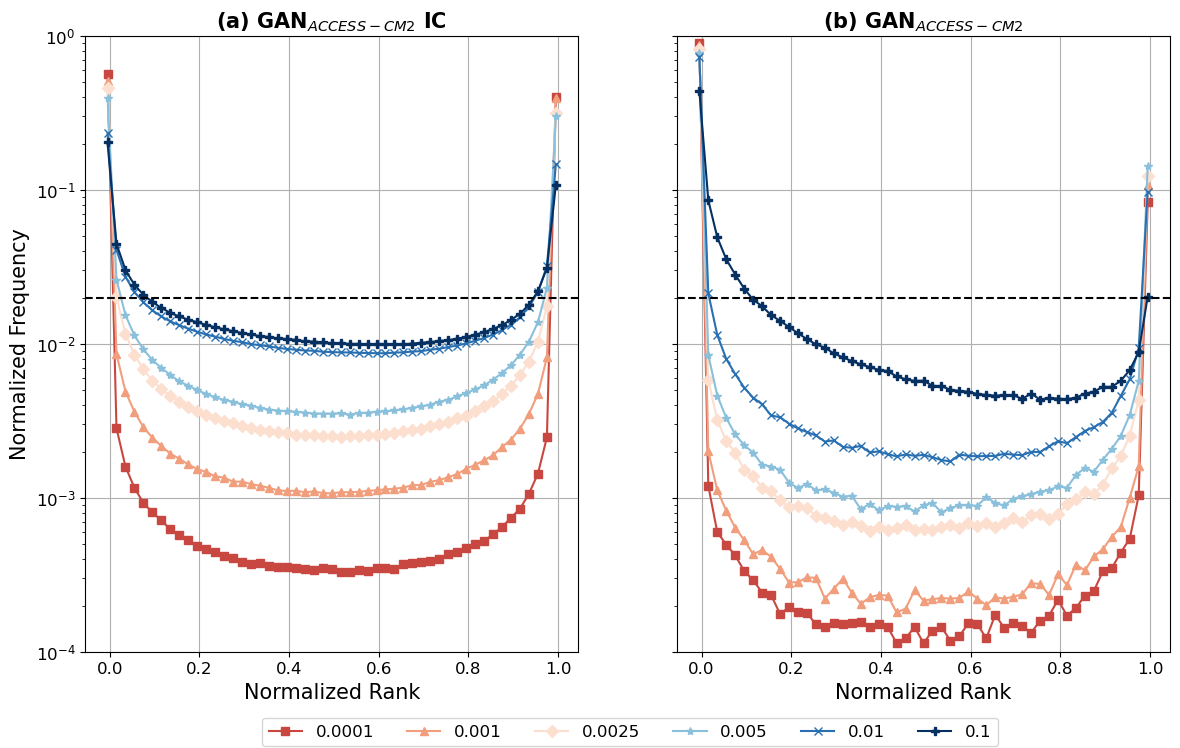

In [297]:
#outputs, bins, arrays = plt.hist(dfrank.isel(experiment =-1).values.ravel(), bins = np.arange(0.00,1.02, 0.02))
cmap = plt.cm.RdBu

marker_types = ['o', 's', '^', 'D', '*', 'x', 'P']
# Generate seven distinct colors, excluding white
colors = [cmap(i) for i in np.linspace(0,1, 25)]
colors_hist = [colors[0], colors[4], colors[7], colors[10], colors[17], colors[21], colors[-1]]
fig, ax = plt.subplots(1,2, figsize = (14, 8), sharex =True, sharey =True)
for i in range(1, dfrank_ic.experiment.size):
    print(i)

    outputs = z2[i]/ sum(z2[i])#(dfrank_ic.lat.size * dfrank_ic.lon.size * dfrank_ic.time.size)
    ax[0].plot(bins[:-1], outputs, label =f'{dfrank_ic.experiment.values[i]}', color = colors_hist[i], marker = marker_types[i])

for i in range(1, dfrank_ic.experiment.size):
    print(i)

    outputs = z23[i]/ sum(z23[i])#(dfrank_ic.lat.size * dfrank_ic.lon.size * dfrank_ic.time.size)
    ax[1].plot(bins[:-1], outputs, label =f'{dfrank_ic.experiment.values[i]}', color = colors_hist[i], marker = marker_types[i])


# outputs = z22[1]/ (dfrank_ic_ac.lat.size * dfrank_ic_ac.lon.size * dfrank_ic_ac.time.size)
# ax[1].plot(bins[:-1], outputs, label =f'{dfrank_ic_ac.experiment.values[1]}', color = colors_hist[3], marker = marker_types[3])

# outputs = z22[-1]/ (dfrank_ic_ac.lat.size * dfrank_ic_ac.lon.size * dfrank_ic_ac.time.size)
# ax[1].plot(bins[:-1], outputs, label =f'{dfrank_ic_ac.experiment.values[-1]}', color = colors_hist[-1], marker = marker_types[-1])
ax[0].axhline(0.02, color ='k', ls ='--')

ax[0].set_yscale('log')

ax[1].axhline(0.02, color ='k', ls ='--')

ax[1].set_yscale('log')
ax[0].grid('on')
ax[1].grid('on')
fig.legend(labels=rmse_lr.experiment.values[1:], loc='lower center', ncol=7, fontsize =12, bbox_to_anchor = (0.45, -0.008))
ax[0].set_title('(a) GAN$_{ACCESS-CM2}$ IC', weight ='bold', fontsize =15)
ax[1].set_title('(b) GAN$_{ACCESS-CM2}$', weight ='bold', fontsize =15)
ax[0].tick_params(labelsize =12)
ax[1].tick_params(labelsize =12)
ax[0].set_ylim(1e-4,1)
ax[1].set_ylim(1e-4,1)
ax[0].set_xlabel('Normalized Rank', fontsize =15)
ax[1].set_xlabel('Normalized Rank', fontsize =15)
ax[0].set_ylabel('Normalized Frequency', fontsize =15)
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_hist_v1_extreme.pdf', dpi =500)
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/rank_hist_v1_extreme.png', dpi =500)

1
2
3
4
5
6
1
2
3
4
5
6


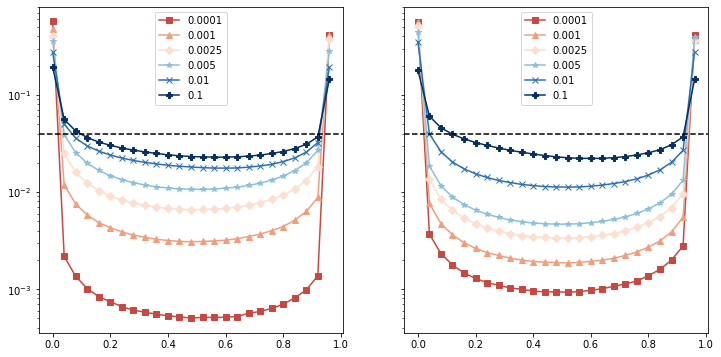

In [ ]:
#outputs, bins, arrays = plt.hist(dfrank.isel(experiment =-1).values.ravel(), bins = np.arange(0.00,1.02, 0.02))
cmap = plt.cm.RdBu

marker_types = ['o', 's', '^', 'D', '*', 'x', 'P']
# Generate seven distinct colors, excluding white
colors = [cmap(i) for i in np.linspace(0,1, 25)]
colors_hist = [colors[0], colors[4], colors[7], colors[10], colors[17], colors[21], colors[-1]]
fig, ax = plt.subplots(1,2, figsize = (12, 6), sharex =True, sharey =True)
for i in range(1, dfrank_ic.experiment.size):
    print(i)

    outputs = z2[i]/ (dfrank_ic.lat.size * dfrank_ic.lon.size * dfrank_ic.time.size)
    ax[0].plot(bins[:-1], outputs, label =f'{dfrank_ic.experiment.values[i]}', color = colors_hist[i], marker = marker_types[i])

for i in range(1, dfrank_ic.experiment.size):
    print(i)

    outputs = z23[i]/ (dfrank_ic.lat.size * dfrank_ic.lon.size * dfrank_ic.time.size)
    ax[1].plot(bins[:-1], outputs, label =f'{dfrank_ic.experiment.values[i]}', color = colors_hist[i], marker = marker_types[i])


# outputs = z22[1]/ (dfrank_ic_ac.lat.size * dfrank_ic_ac.lon.size * dfrank_ic_ac.time.size)
# ax[1].plot(bins[:-1], outputs, label =f'{dfrank_ic_ac.experiment.values[1]}', color = colors_hist[3], marker = marker_types[3])

# outputs = z22[-1]/ (dfrank_ic_ac.lat.size * dfrank_ic_ac.lon.size * dfrank_ic_ac.time.size)
# ax[1].plot(bins[:-1], outputs, label =f'{dfrank_ic_ac.experiment.values[-1]}', color = colors_hist[-1], marker = marker_types[-1])
ax[0].axhline(0.04, color ='k', ls ='--')
ax[0].legend()
ax[0].set_yscale('log')

ax[1].axhline(0.04, color ='k', ls ='--')
ax[1].legend()
ax[1].set_yscale('log')

In [358]:
dsets_lr = no_cons
ens_mean = dsets_lr.sel(time = dsets_lr.time).clip(0,500).isel(member = slice(0,10)).mean("member")

In [360]:

rmse_lr = np.sqrt(abs(ens_mean.sel(time = common_times) - ground_truth.sel(time = common_times).pr*3600*24)**2)
rmss_lr = np.sqrt((abs(ens_mean.sel(time = common_times)  - dsets_lr.isel(member = slice(0,10)).sel(time = common_times))**2).mean("member"))

with ProgressBar():
    rmse_lr = rmse_lr.load()
    rmss_lr = rmss_lr.load()

In [361]:
dsets_lr = ic_data
ens_mean = dsets_lr.sel(time = dsets_lr.time).clip(0,500).isel(member = slice(0,10)).mean("member")
#ens_mean = dsets_lr.sel(time = dsets_lr.time).clip(0,500).mean("member")

In [363]:

rmse_lr_ic = np.sqrt(abs(ens_mean - ground_truth.pr.sel(time = dsets_lr.time)*3600*24)**2)
rmss_lr_ic = np.sqrt((abs(ens_mean- dsets_lr.isel(member = slice(0,10)).sel(time = dsets_lr.time).clip(0,500))**2).mean("member"))

with ProgressBar():
    rmse_lr_ic = rmse_lr_ic.load()
    rmss_lr_ic = rmss_lr_ic.load()

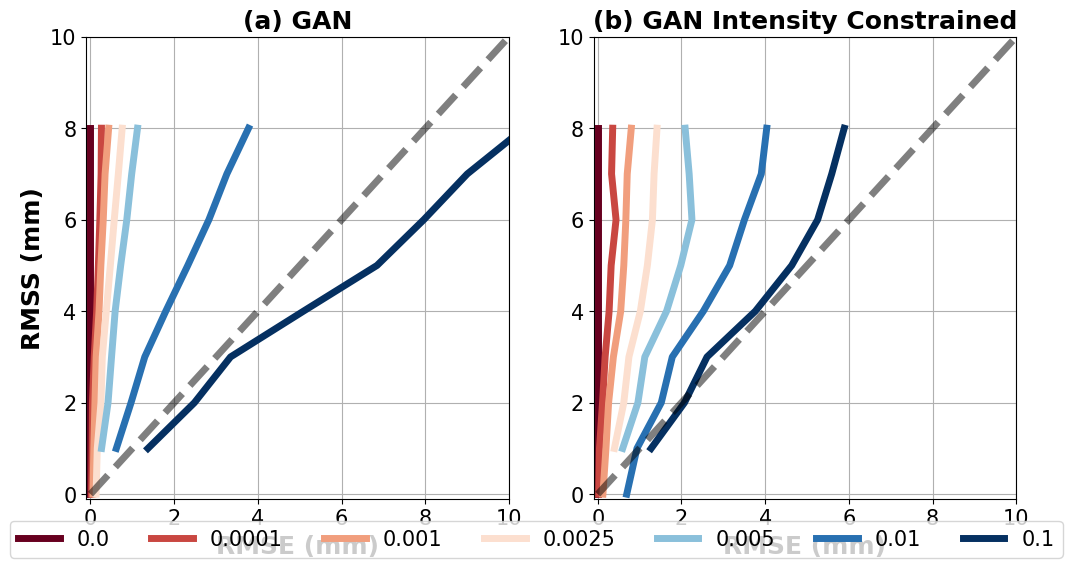

In [364]:




from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize = (12, 6))
factor = (10)/(10+1)
factor2 = (10)/(10-1)
bins =np.arange(0,10,1)
for i in range(7):
    x1 = binned_statistic(values=factor2 * rmss_lr.isel(experiment =i).mean("time").pr.values.ravel(), x=factor*rmse_lr.isel(experiment =i).mean("time").pr.values.ravel(),  statistic ='mean', bins =bins)
    #print(f"spread-ratio:{np.mean((1.11 * rmss_lr.isel(experiment =i).pr.values.ravel())/(0.9* rmse_lr.isel(experiment =i).pr.values.ravel()))}")
    ax[0].plot(x1[0], bins[:-1], label ='$\lambda_{adv}$=' +f'{rmse_lr.experiment.values[i]}', color = colors_hist[i], lw =5)
    x1 = binned_statistic(values=factor2 * rmss_lr_ic.isel(experiment =i).mean("time").pr.values.ravel(), x=factor*rmse_lr_ic.isel(experiment =i).mean("time").pr.values.ravel(),  statistic ='mean', bins =bins)
    #print(f"spread-ratio:{np.mean((1.11 * rmss_lr.isel(experiment =i).pr.values.ravel())/(0.9* rmse_lr.isel(experiment =i).pr.values.ravel()))}")
    ax[1].plot(x1[0], bins[:-1], label ='$\lambda_{adv}$=' +f'{rmse_lr.experiment.values[i]}', color = colors_hist[i], lw =5)
    #ax[1].scatter(x1[0], bins[:-1], color = colors_hist[i], marker = marker_types[i], s=35)

ax[0].plot([0,15], [0,15], ls ='--', color ='k', lw =5,alpha =0.5)
ax[0].grid('on')

ax[1].plot([0,15], [0,15], ls ='--', color ='k', lw =5,alpha =0.5)
ax[1].grid('on')


ax[0].set_xlim(-0.1, 10)
ax[0].set_ylim(-0.1,10)
ax[1].set_xlim(-0.1, 10)
ax[1].set_ylim(-0.1,10)

ax[0].set_xlabel('RMSE (mm)', fontsize=18, weight ='bold')
ax[1].set_xlabel('RMSE (mm)', fontsize=18, weight ='bold')
ax[0].set_ylabel('RMSS (mm)', fontsize=18, weight ='bold')
#ax[1].set_xlabel('RMSE (mm)', fontsize=18, weight ='bold')

ax[0].set_title('(a) GAN', weight ='bold', fontsize =18)
ax[1].set_title('(b) GAN Intensity Constrained', weight ='bold', fontsize =18)
ax[0].tick_params(labelsize =15)
ax[1].tick_params(labelsize =15)

#fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/overall_results/dispersion_relationship_9_4_24.png', dpi =700, bbox_inches ='tight')
#ax4 = fig.add_axes([0.1, 0.1, 0.5, 0.1])
fig.legend(labels=rmse_lr.experiment.values, loc='lower center', ncol=7, fontsize =15)



In [ ]:
climo = df2.isel(member = slice(0,10)).groupby('time.season').mean(["time","member"])

In [ ]:

climo_v1 = df.sel(experiment = df2.experiment).isel(member =slice(0,10)).groupby('time.season').mean(["time","member"])

In [ ]:
climo_gt = ground_truth.sel(GCM ='EC-Earth3').sel(time=df.time).groupby('time.season').mean(["time"]) * 86400

In [ ]:
errors = abs(climo_gt.pr - climo)

In [ ]:
errors2 = abs(climo_gt.pr - climo_v1)

In [ ]:
errors.mean(["lat","lon"]).isel(experiment =-1)

<xarray.Dataset>
Dimensions:     (season: 4)
Coordinates:
    experiment  float64 0.1
  * season      (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    pr          (season) float64 0.6108 0.8459 0.7764 0.4623

In [ ]:
errors2.mean(["lat","lon"]).isel(experiment =-1)

<xarray.Dataset>
Dimensions:     (season: 4)
Coordinates:
    experiment  float64 0.1
  * season      (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    pr          (season) float64 0.5465 0.5333 0.5546 0.5453

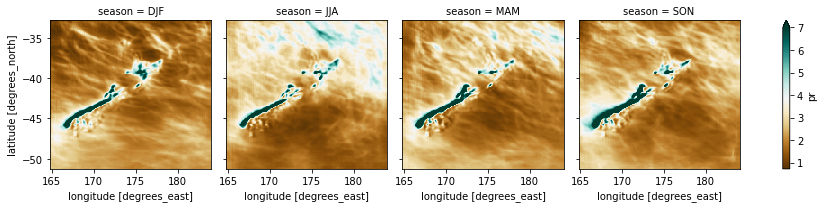

In [ ]:
climo.pr.isel(experiment =-1).plot(col ="season", vmax =7, cmap ='BrBG')

In [ ]:

climo_v1 = df2.sel(experiment = df2.experiment).groupby('time.season').mean()

In [ ]:
730*7*50

255500

In [ ]:
ground_truth

<xarray.Dataset>
Dimensions:     (time: 51100, GCM: 5, bnds: 2, lon: 179, lat: 172)
Coordinates:
  * time        (time) object 1960-01-01 12:00:00 ... 2099-12-31 12:00:00
  * lon         (lon) float32 164.9 165.0 165.1 165.2 ... 183.7 183.9 184.0
  * lat         (lat) float32 -51.21 -51.11 -51.0 ... -33.07 -32.97 -32.86
  * GCM         (GCM) object 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
Dimensions without coordinates: bnds
Data variables:
    time_bnds   (GCM, time, bnds) object ...
    lon_bnds    (GCM, lon, bnds) float32 ...
    lat_bnds    (GCM, lat, bnds) float32 ...
    pr          (GCM, time, lat, lon) float32 ...
    psl         (GCM, time, lat, lon) float32 ...
    sfcWind     (GCM, time, lat, lon) float32 ...
    sfcWindmax  (GCM, time, lat, lon) float32 ...
    tasmax      (GCM, time, lat, lon) float32 ...
    tasmin      (GCM, time, lat, lon) float32 ...
Attributes: (12/28)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    history:         Tue Mar 12 14:54:26 2024: cdo merge /nesi/project/niwa00...
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    il:              288
    ...              ...
    BC_version:      no output bias correction
    CMOR_v:          v1.0 Public
    CDO_call:        daymean computed on hourly data
    project:         NIWA CMIP6 Downscaling
    contact:         Peter Gibson (peter.gibson@niwa.co.nz)
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....

In [ ]:
common_times = ground_truth.time.to_index().intersection(df.time.to_index())
with ProgressBar():
    ground_truth = ground_truth.sel(time = common_times)

In [ ]:
common_times_updated = ground_truth.time.to_index().intersection(df.time.to_index())[0:50]

In [ ]:
df

<xarray.Dataset>
Dimensions:     (experiment: 7, member: 50, time: 730, lat: 172, lon: 179)
Coordinates:
  * experiment  (experiment) float64 0.0 0.0001 0.001 0.0025 0.005 0.01 0.1
  * lon         (lon) float32 164.9 165.0 165.1 165.2 ... 183.7 183.9 184.0
  * lat         (lat) float32 -51.21 -51.11 -51.0 ... -33.07 -32.97 -32.86
    GCM         <U10 'ACCESS-CM2'
  * time        (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2014-12-31
Dimensions without coordinates: member
Data variables:
    pr          (experiment, member, time, lat, lon) float32 2.123 ... 0.5398
Attributes: (12/28)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    history:         Tue Mar 12 14:54:26 2024: cdo merge /nesi/project/niwa00...
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    il:              288
    ...              ...
    BC_version:      no output bias correction
    CMOR_v:          v1.0 Public
    CDO_call:        daymean computed on hourly data
    project:         NIWA CMIP6 Downscaling
    contact:         Peter Gibson (peter.gibson@niwa.co.nz)
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....

In [ ]:
dfrank = (df.pr.sel(time = common_times).where(df.pr.sel(time = common_times)> 0.001, 0.0).clip(0,1000) > ground_truth.pr.sel(GCM ='EC-Earth3').sel(time = common_times)*3600*24).sum("member")/50.0

In [ ]:
z2 =[]
bins = np.arange(0.00,1.05, 0.05)
for i in range(dfrank.experiment.size):
    z1 = binned_statistic(x =  dfrank.isel(experiment =i).values.ravel(),values =np.ones([1]), statistic = 'count', bins =bins)
    z2.append(z1[0])

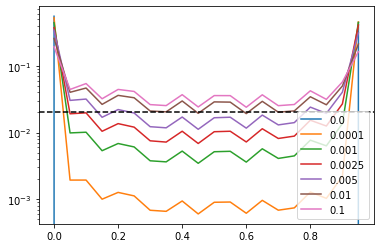

In [ ]:
#outputs, bins, arrays = plt.hist(dfrank.isel(experiment =-1).values.ravel(), bins = np.arange(0.00,1.02, 0.02))
fig, ax = plt.subplots()
for i in range(dfrank.experiment.size):

    outputs = z2[i]/ (dfrank.lat.size * dfrank.lon.size * dfrank.time.size)
    ax.plot(bins[:-1], outputs, label =f'{dfrank.experiment.values[i]}')
ax.axhline(0.02, color ='k', ls ='--')
ax.legend()
ax.set_yscale('log')

In [367]:
!pip show numpy

Name: numpy
Version: 1.24.4
Summary: Fundamental package for array computing in Python
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD-3-Clause
Location: /scale_wlg_persistent/filesets/project/niwa00018/share/lib/python3.8/site-packages
Requires: 
Required-by: scipy, opt-einsum, ml-dtypes, jaxlib, jax, yellowbrick, wordcloud, visions, umap-learn, thinc, statsmodels, spacy, shap, pyod, pyLDAvis, pycaret, phik, patsy, pandas, pandas-profiling, numexpr, mlflow, missingno, lightgbm, kmodes, imbalanced-learn, ImageHash, gensim, cufflinks, Boruta, blis, xarray, tifffile, tables, stratify, seaborn, scitools-iris, scikit-learn, scikit-image, PyWavelets, pyresample, pykdtree, pyerfa, numba, netCDF4, mkl-random, mkl-fft, matplotlib, imageio, h5py, cftime, cf-units, cell-tree2d, Cartopy, Bottleneck, bokeh, bkcharts, basemap, astropy


In [ ]:

outputs, bins, arrays = plt.hist(rank.pr.values.ravel(), bins = np.arange(0.00,1.05, 0.04))

outputs = outputs/ (rank.lat.size * rank.lon.size * rank.time.size)


plt.plot(bins[:-1], outputs)
plt.axhline(0.04, color ='k', ls ='--')

rank = (fields_iten.isel(experiment =-1).where(fields_iten.isel(experiment =-1)>0.001, 0.0).clip(0,1000) > y.sel(time = fields_iten.time)*3600*24).sum("member")/25.0
outputs2, bins, arrays = plt.hist(rank.pr.values.ravel(), bins = np.arange(0.00,1.05, 0.04))

outputs2 = outputs2/ (rank.lat.size * rank.lon.size * rank.time.size)

rank = (fields.isel(experiment =-2).where(fields.isel(experiment =-1)>0.001, 0.0).clip(0,1000) > y.sel(time = fields_iten.time)*3600*24).sum("member")/25.0
outputs3, bins, arrays = plt.hist(rank.pr.values.ravel(), bins = np.arange(0.00,1.05, 0.04))

outputs3 = outputs3/ (rank.lat.size * rank.lon.size * rank.time.size)

rank = (fields.isel(experiment =-3).where(fields.isel(experiment =-1)>0.001, 0.0).clip(0,1000) > y.sel(time = fields_iten.time)*3600*24).sum("member")/25.0
outputs4, bins, arrays = plt.hist(rank.pr.values.ravel(), bins = np.arange(0.00,1.05, 0.04))

outputs4 = outputs4/ (rank.lat.size * rank.lon.size * rank.time.size)

<xarray.Dataset>
Dimensions:     (experiment: 7, member: 50, time: 730, lat: 172, lon: 179)
Coordinates:
  * experiment  (experiment) float64 0.0 0.0001 0.001 0.0025 0.005 0.01 0.1
  * lon         (lon) float32 164.9 165.0 165.1 165.2 ... 183.7 183.9 184.0
  * lat         (lat) float32 -51.21 -51.11 -51.0 ... -33.07 -32.97 -32.86
    GCM         object ...
  * time        (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2014-12-31
Dimensions without coordinates: member
Data variables:
    pr          (experiment, member, time, lat, lon) float32 ...
Attributes: (12/28)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    history:         Tue Mar 12 14:54:26 2024: cdo merge /nesi/project/niwa00...
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    il:              288
    ...              ...
    BC_version:      no output bias correction
    CMOR_v:          v1.0 Public
    CDO_call:        daymean computed on hourly data
    project:         NIWA CMIP6 Downscaling
    contact:         Peter Gibson (peter.gibson@niwa.co.nz)
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....